In [1]:
from PIL import Image
import os
import numpy as np
import time
import pandas as pd
import re
from tqdm import tqdm

In [41]:
from PIL import Image
import os
import numpy as np
import time

def pHash(image,leng=32,wid=32):
    image = np.array(image.resize((leng,wid), Image.ANTIALIAS).convert('L'), 'f')
    A=[]
    for i in range(0,32):
        for j in range(0,32):
            if i==0:
                a=np.sqrt(1/32)
            else:
                a=np.sqrt(2/32)
            A.append(a*np.cos(np.pi*(2*j+1)*i/(2*32)))
    dct = np.dot(np.dot(image,np.reshape(A,(32,32))),np.transpose(image))
    b = dct[10:18,10:18]
    hash=[]
    avreage = np.mean(b)
    for i in range(8): 
        for j in range(8): 
            if b[i,j] >= avreage: 
                hash.append(1) 
            else: 
                hash.append(0)
    return hash

def Hamming_distance(hash1,hash2): 
    num = 0
    for index in range(len(hash1)): 
        if hash1[index] != hash2[index]: 
            num += 1
    return num

def similarity(dist):
    return 1 - dist * 1.0 / 64

a_dist is 34, similarity is 0.468750, time is 0.005986
p_dist is 19, similarity is 0.703125, time is 0.009963
d_dist is 37, similarity is 0.421875, time is 0.012973


In [3]:
similarity(Hamming_distance(aHash(image1),aHash(image2)))

0.46875

In [63]:
train_dir = 'COMP90086_2021_Project_train/train/'
test_dir = 'COMP90086_2021_Project_test/test/'

# all the train images name
train_dir_list = os.listdir('COMP90086_2021_Project_train/train/')
# all the test images name
test_dir_list = os.listdir('COMP90086_2021_Project_test/test/')

train_datalabels =  'COMP90086_2021_Project_train/train.csv'
test_datalabels = 'COMP90086_2021_Project_test/imagenames.csv'

In [43]:
ground_truth=pd.read_csv(train_datalabels,header=0,index_col=0)

predict = pd.read_csv(test_datalabels)
predict['x'] = None
predict['y'] = None

In [44]:
import json

test_dict = {}

for test_img_file in tqdm(test_dir_list):
    if re.match(r'(.*?jpg)',test_img_file) is not None:
        test_img = Image.open(test_dir+test_img_file)
        test_dict[test_img_file.split(".")[0]] = pHash(test_img)

with open('test_hash_15.json', 'w') as json_file:
    json.dump(test_dict, json_file)
with open('test_hash_15.json', 'r') as json_file:
    load_dict = json.load(json_file)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1201/1201 [00:15<00:00, 79.52it/s]


In [45]:
import json

train_dict = {}

for train_img_file in tqdm(train_dir_list):
    if re.match(r'(.*?jpg)',train_img_file) is not None:
        train_img = Image.open(train_dir+train_img_file)
        train_dict[train_img_file.split(".")[0]] = pHash(train_img)

with open('train_hash_15.json', 'w') as json_file:
    json.dump(train_dict, json_file)
with open('train_hash_15.json', 'r') as json_file:
    load_dict = json.load(json_file)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7501/7501 [01:32<00:00, 80.76it/s]


In [46]:
count = 0

with open('test_hash_15.json', 'r') as json_file:
    test_dict = json.load(json_file)
with open('train_hash_15.json', 'r') as json_file:
    train_dict = json.load(json_file)
    
for test_name in tqdm(test_dict):
    test_hash = test_dict[test_name]
    most_sim = 0
    for train_name in train_dict:
        train_hash = train_dict[train_name]
        sim = similarity(Hamming_distance(test_hash,train_hash))
        
        if sim > 0.7:
            if most_sim < sim:
                most_sim = sim
                best_name = train_name
    x = ground_truth.loc[best_name][0]
    y = ground_truth.loc[best_name][1]
    predict.loc[predict["id"]==test_name,"x"] = x
    predict.loc[predict["id"]==test_name,"y"] = y
    predict.to_csv('only_phash_15.csv',index=False, encoding='utf-8')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:59<00:00, 20.28it/s]


In [61]:
def sift_match(current_img, matching_img):
    # Initiate SIFT detector
    sift = cv2.SIFT_create() 
    
    # Compute SIFT keypoints and descriptors
    current_kp, current_des = sift.detectAndCompute(current_img,None)
    matching_kp, matching_des = sift.detectAndCompute(matching_img,None)
    
    if matching_kp == [] or len(matching_kp)<5:
        return 0
    
    # FLANN parameters and initialize
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 3)
    search_params = dict(checks=20)   # or pass empty dictionary
    flann = cv2.FlannBasedMatcher(index_params,search_params)

    # Matching descriptor using KNN algorithm
    matches = flann.knnMatch(current_des,matching_des,k=2)

    # Create a mask to draw all good matches
    matchesMask = []

    # Store all good matches as per Lowe's Ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.6*n.distance:
            good.append(m)
            matchesMask.append([1,0]) # Match
        else:
            matchesMask.append([0,0]) # Mismatch
    MIN_MATCH_NUM = 4

    if len(good)> MIN_MATCH_NUM:
        # If enough matches are found, we extract the positions of the matched keypoints in both images. 
        # They are passed to find the perspective transformation. 

        # Estimate homography between two images
        ptsA = np.float32([current_kp[m.queryIdx].pt for m in good]).reshape(-1,1,2)
        ptsB = np.float32([matching_kp[m.trainIdx].pt for m in good]).reshape(-1,1,2)
        H, status = cv2.findHomography(ptsA, 
                                       ptsB, 
                                       cv2.RANSAC, 
                                       ransacReprojThreshold = 5, 
                                       maxIters = 100)

        matchesMask = status.ravel().tolist()
    else:
        # Otherwise, print that “Not enough matches are found”.
        # print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_NUM) )
        matchesMask = None

    return len(good)

[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
[('IMG3442', 121), ('IMG3403', 95), ('IMG3436', 71), ('IMG4042', 60), ('IMG3897', 46), ('IMG3197', 41), ('IMG3893', 39), ('IMG3466', 33), ('IMG3098', 33), ('IMG2763', 31), ('IMG3214', 31), ('IMG4043', 30), ('IMG4214', 27), ('IMG3109', 26), ('IMG3199', 26), ('IMG2796', 25), ('IMG3369', 25), ('IMG3868', 24), ('IMG3527', 24), ('IMG3304', 23), ('IMG3535', 23), ('IMG2872', 22), ('IMG3652', 22), ('IMG3693', 22), ('IMG4089', 21), ('IMG4104', 21), ('IMG2941', 20), ('IMG3259', 20), ('IMG3015', 19), ('IMG2807', 19), ('IMG3462', 19), ('IMG3430', 19), ('IMG3579', 19), ('IMG3769', 19), ('IMG4236', 18), ('IMG3663', 18), ('IMG4154', 18), ('IMG4167', 18), ('IMG4105', 18), ('IMG3383', 18), ('IMG3246', 18), ('IMG4065', 18), ('IMG3866', 17), ('IMG3984', 17), ('IMG3743', 17), ('IMG4033', 16), ('IMG3169', 16), ('IMG3

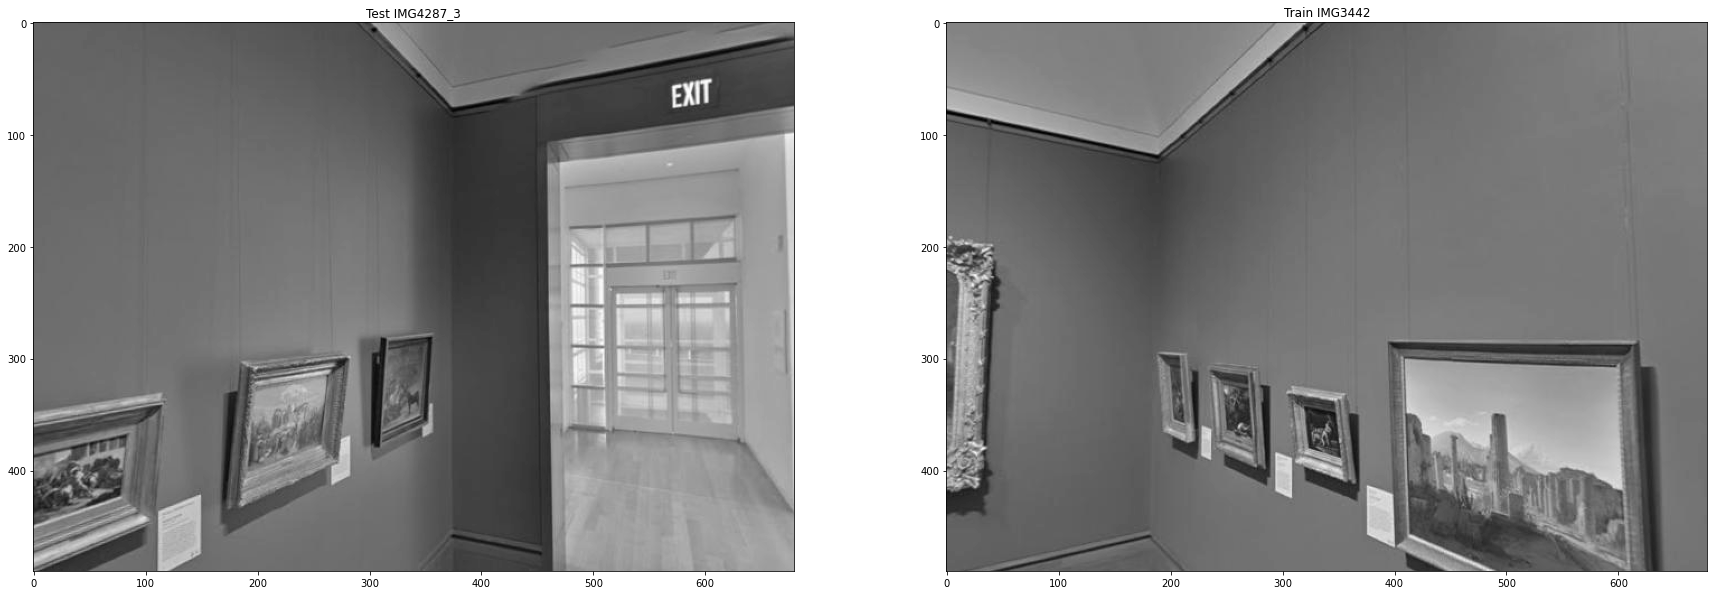

In [82]:
import cv2
from matplotlib import pyplot as plt

count = 0

with open('test_hash_15.json', 'r') as json_file:
    test_dict = json.load(json_file)
with open('train_hash_15.json', 'r') as json_file:
    train_dict = json.load(json_file)
    

test_hash = test_dict['IMG4287_3']
most_sim = 0

sim_set = {}

for train_name in train_dict:
    train_hash = train_dict[train_name]
    sim = similarity(Hamming_distance(test_hash,train_hash))
        
    if sim >= 0.75:
        sim_set[train_name]=sim
#         if most_sim < sim:
#             most_sim = sim
#             best_name = train_name

sim_set = sorted(sim_set.items(), key=lambda d:d[1],reverse=True) 

merge_set = {}
for s in iter(sim_set):
    name = s[0].split('_')[0]
    if name not in merge_set:
        # count the number of showing
        merge_set[name] = 1
    else:
        merge_set[name]+=1

new_set = {k: v for k, v in merge_set.items() if v >= 3}


img1 = cv2.imread(test_dir+'IMG4287_3'+'.jpg', cv2.IMREAD_GRAYSCALE)
# img2 = cv2.imread(train_dir+best_name+'.jpg', cv2.IMREAD_GRAYSCALE)


sift_match_num = 0
sift_set = {}
for s in new_set:
    for i in range(5):
        num = sift_match(img1,cv2.imread(train_dir+s+'_'+str(i+1)+'.jpg', cv2.IMREAD_GRAYSCALE))
        if s not in sift_set:
            # count the number of showing
            sift_set[s] = num
        else:
            sift_set[s]+=num
sift_set = sorted(sift_set.items(), key=lambda d:d[1],reverse=True) 
print(sift_set)

img2 = cv2.imread(train_dir+best_name+'_1.jpg', cv2.IMREAD_GRAYSCALE)
        
plt.subplots(figsize=(30, 30))
plt.subplot(1,2,1)
plt.title('Test IMG4287_3')
plt.imshow(img1,cmap='gray')
plt.subplot(1,2,2)
plt.title('Train '+best_name)
plt.imshow(img2,cmap='gray')

In [111]:
# find similarity>0.75 and show up >3 times' img，sum the number of characteristic of these img and get the maximum one
import cv2
import time
from matplotlib import pyplot as plt

count = 0

with open('test_hash_15.json', 'r') as json_file:
    test_dict = json.load(json_file)
with open('train_hash_15.json', 'r') as json_file:
    train_dict = json.load(json_file)


for test_name in tqdm(test_dict):
    start_time = time.time()
    test_hash = test_dict[test_name]
    
    sim_set = {}
    for train_name in train_dict:
        train_hash = train_dict[train_name]
        #print(train_hash)
        sim = similarity(Hamming_distance(test_hash,train_hash))

        if sim >= 0.75:
            sim_set[train_name]=sim
    #         if most_sim < sim:
    #             most_sim = sim
    #             best_name = train_name

    sim_set = sorted(sim_set.items(), key=lambda d:d[1],reverse=True) 
    #print('sim_set: ')
    #print(sim_set)
    merge_set = {}
    for s in iter(sim_set):
        name = s[0].split('_')[0]
        if name not in merge_set:
            # count the number of showing
            merge_set[name] = 1
        else:
            merge_set[name]+=1
        
    new_set = {k: v for k, v in merge_set.items() if v >= 3}
    
    merge_set = sorted(merge_set.items(), key=lambda d:d[1],reverse=True)
    img1 = cv2.imread(test_dir+test_name+'.jpg', cv2.IMREAD_GRAYSCALE)
    sift_match_num = 0
    sift_set = {}
    for s in new_set:
        for i in range(5):
            num = sift_match(img1,cv2.imread(train_dir+s+'_'+str(i+1)+'.jpg', cv2.IMREAD_GRAYSCALE))
            if s not in sift_set:
                # count the number of showing
                sift_set[s] = num
            else:
                sift_set[s]+=num
    sift_set = sorted(sift_set.items(), key=lambda d:d[1],reverse=True) 
    #print(sift_set)

    if len(sift_set)<2:
        if len(sift_set) == 0:
            x = ground_truth.loc[sim_set[0][0]+'_1'][0]
            y = ground_truth.loc[sim_set[0][0]+'_1'][1]
        else:
            x = ground_truth.loc[merge_set[0][0]+'_1'][0]
            y = ground_truth.loc[merge_set[0][0]+'_1'][1] 
    else:
        first = sift_set[0][0]+'_1'
        second = sift_set[1][0]+'_1'
        x = (ground_truth.loc[first][0] + ground_truth.loc[second][0])/2
        y = (ground_truth.loc[first][1] + ground_truth.loc[second][1])/2
    predict.loc[predict["id"]==test_name,"x"] = x
    predict.loc[predict["id"]==test_name,"y"] = y
    predict.to_csv('only_phash_merge.csv',index=False, encoding='utf-8')
    end_time = time.time()
    print(end_time-start_time)

# 3403 3442 same place but different location

  0%|                                                                                                                    | 1/1200 [01:15<25:05:46, 75.35s/it]

75.35174345970154


  0%|▏                                                                                                                   | 2/1200 [01:21<11:31:09, 34.62s/it]

6.0999674797058105


  0%|▎                                                                                                                    | 3/1200 [01:22<6:28:56, 19.50s/it]

1.5035688877105713


  0%|▍                                                                                                                    | 4/1200 [01:37<5:50:39, 17.59s/it]

14.67210578918457
0.037778377532958984


  0%|▌                                                                                                                    | 6/1200 [01:40<2:58:58,  8.99s/it]

2.705488681793213


  1%|▋                                                                                                                    | 7/1200 [02:08<4:44:28, 14.31s/it]

28.34045386314392


  1%|▊                                                                                                                    | 8/1200 [02:57<7:57:56, 24.06s/it]

48.90836763381958


  1%|▉                                                                                                                    | 9/1200 [02:59<5:53:54, 17.83s/it]

2.358781099319458


  1%|▉                                                                                                                  | 10/1200 [04:03<10:18:10, 31.17s/it]

63.70128893852234


  1%|█▎                                                                                                                  | 14/1200 [04:30<4:21:16, 13.22s/it]

26.49122405052185
0.03775787353515625
0.03124213218688965
0.04686284065246582


  1%|█▍                                                                                                                  | 15/1200 [04:33<3:39:41, 11.12s/it]

3.2293541431427
0.031241655349731445


  1%|█▋                                                                                                                  | 17/1200 [05:34<6:03:08, 18.42s/it]

61.15583872795105


  2%|█▋                                                                                                                  | 18/1200 [05:35<4:48:30, 14.65s/it]

0.5480642318725586


  2%|█▊                                                                                                                  | 19/1200 [06:15<6:45:35, 20.61s/it]

40.37146544456482


  2%|█▉                                                                                                                  | 20/1200 [06:16<5:08:08, 15.67s/it]

0.7484190464019775
0.03774762153625488
0.031245946884155273


  2%|██▏                                                                                                                 | 23/1200 [06:40<3:50:59, 11.78s/it]

24.301004648208618
0.04686903953552246
0.03124094009399414


  2%|██▌                                                                                                                 | 26/1200 [07:09<3:31:15, 10.80s/it]

28.32717275619507
0.037778377532958984


  2%|██▋                                                                                                                 | 28/1200 [07:31<3:32:39, 10.89s/it]

22.18496799468994


  2%|██▊                                                                                                                 | 29/1200 [08:12<5:11:36, 15.97s/it]

40.67417335510254


  2%|██▉                                                                                                                | 30/1200 [09:46<10:11:27, 31.36s/it]

94.5341386795044


  3%|██▉                                                                                                                 | 31/1200 [10:04<9:15:45, 28.52s/it]

18.403764724731445


  3%|███                                                                                                                | 32/1200 [10:52<10:43:26, 33.05s/it]

47.5518581867218


  3%|███▏                                                                                                               | 33/1200 [11:38<11:48:57, 36.45s/it]

46.440847873687744


  3%|███▎                                                                                                                | 34/1200 [11:42<8:56:57, 27.63s/it]

3.301300287246704
0.03775453567504883


  3%|███▍                                                                                                                | 36/1200 [12:28<8:18:51, 25.71s/it]

46.349915742874146


  3%|███▌                                                                                                                | 37/1200 [12:32<6:38:04, 20.54s/it]

3.7533838748931885


  3%|███▋                                                                                                                | 38/1200 [12:53<6:39:34, 20.63s/it]

20.913477420806885


  3%|███▋                                                                                                             | 39/1200 [45:16<170:45:40, 529.49s/it]

1943.3481731414795


  3%|███▊                                                                                                             | 40/1200 [45:55<127:14:00, 394.86s/it]

38.77657127380371


  3%|███▉                                                                                                              | 41/1200 [46:48<96:07:41, 298.59s/it]

52.94240474700928


  4%|███▉                                                                                                              | 42/1200 [48:44<79:14:52, 246.37s/it]

116.5455675125122


  4%|████                                                                                                              | 43/1200 [48:48<56:31:22, 175.87s/it]

3.8469736576080322


  4%|████▏                                                                                                             | 44/1200 [49:17<42:34:56, 132.61s/it]

28.428868293762207


  4%|████▎                                                                                                             | 45/1200 [49:51<33:14:33, 103.61s/it]

34.437559843063354


  4%|████▎                                                                                                             | 46/1200 [51:30<32:48:14, 102.34s/it]

99.30516409873962


  4%|████▌                                                                                                              | 47/1200 [52:00<25:52:51, 80.81s/it]

30.023964881896973


  4%|████▌                                                                                                              | 48/1200 [52:24<20:20:33, 63.57s/it]

23.040756225585938


  4%|████▋                                                                                                              | 49/1200 [52:53<17:02:02, 53.28s/it]

29.130237102508545


  4%|████▊                                                                                                              | 50/1200 [52:58<12:26:55, 38.97s/it]

5.45803689956665


  4%|████▉                                                                                                              | 51/1200 [54:07<15:18:13, 47.95s/it]

68.95617318153381


  4%|████▉                                                                                                              | 52/1200 [55:33<18:55:57, 59.37s/it]

86.067302942276


  4%|█████                                                                                                              | 53/1200 [56:13<17:01:33, 53.44s/it]

39.57684779167175


  4%|█████▏                                                                                                             | 54/1200 [56:14<11:59:56, 37.69s/it]

0.9211452007293701


  5%|█████▎                                                                                                              | 55/1200 [56:20<8:57:28, 28.16s/it]

5.917396545410156
0.040891170501708984


  5%|█████▌                                                                                                              | 57/1200 [57:06<8:11:54, 25.82s/it]

46.134268045425415


  5%|█████▌                                                                                                             | 58/1200 [58:10<11:14:38, 35.45s/it]

64.64164113998413


  5%|█████▌                                                                                                           | 59/1200 [1:00:46<21:12:26, 66.91s/it]

155.76693105697632
0.04188704490661621


  5%|█████▋                                                                                                           | 61/1200 [1:01:05<13:21:48, 42.24s/it]

18.389682292938232


  5%|█████▊                                                                                                           | 62/1200 [1:01:16<11:03:28, 34.98s/it]

11.225386142730713


  5%|█████▉                                                                                                            | 63/1200 [1:01:30<9:23:27, 29.73s/it]

14.036082983016968


  5%|██████                                                                                                           | 64/1200 [1:02:30<11:56:27, 37.84s/it]

60.49175262451172


  5%|██████                                                                                                           | 65/1200 [1:02:48<10:10:11, 32.26s/it]

17.42516040802002


  6%|██████▏                                                                                                          | 66/1200 [1:04:18<15:19:02, 48.63s/it]

90.51872229576111


  6%|██████▎                                                                                                          | 67/1200 [1:05:54<19:31:26, 62.04s/it]

95.44162344932556
0.04986739158630371


  6%|██████▍                                                                                                          | 69/1200 [1:05:55<10:48:00, 34.38s/it]

1.1055519580841064


  6%|██████▋                                                                                                           | 70/1200 [1:06:13<9:32:20, 30.39s/it]

17.983724117279053


  6%|██████▋                                                                                                          | 71/1200 [1:07:35<13:43:18, 43.75s/it]

82.2115228176117


  6%|██████▊                                                                                                          | 72/1200 [1:09:02<17:21:54, 55.42s/it]

87.08486795425415


  6%|██████▊                                                                                                          | 73/1200 [1:09:05<12:44:28, 40.70s/it]

2.4242630004882812
0.05186128616333008


  6%|███████                                                                                                          | 75/1200 [1:10:02<11:05:20, 35.48s/it]

57.775997161865234


  6%|███████▏                                                                                                         | 76/1200 [1:10:41<11:17:38, 36.17s/it]

38.34876084327698
0.044878482818603516


  6%|███████▍                                                                                                          | 78/1200 [1:10:53<7:27:32, 23.93s/it]

12.143705368041992


  7%|███████▍                                                                                                         | 79/1200 [1:12:01<10:34:06, 33.94s/it]

68.36502695083618


  7%|███████▌                                                                                                         | 80/1200 [1:14:38<19:50:05, 63.75s/it]

156.4277687072754


  7%|███████▋                                                                                                         | 81/1200 [1:14:41<14:55:46, 48.03s/it]

2.81191349029541


  7%|███████▋                                                                                                         | 82/1200 [1:14:54<12:01:41, 38.73s/it]

13.499117612838745
0.0458681583404541


  7%|███████▉                                                                                                          | 84/1200 [1:15:03<7:22:59, 23.82s/it]

8.821040630340576
0.04188895225524902


  7%|████████▏                                                                                                         | 86/1200 [1:15:13<5:08:13, 16.60s/it]

9.932082891464233
0.04086112976074219


  7%|████████▎                                                                                                         | 88/1200 [1:16:18<6:53:42, 22.32s/it]

65.50416302680969


  7%|████████▍                                                                                                        | 89/1200 [1:17:51<11:16:18, 36.52s/it]

92.72746634483337
0.038895606994628906
0.038211822509765625


  8%|████████▋                                                                                                         | 92/1200 [1:18:21<7:26:54, 24.20s/it]

29.759833097457886


  8%|████████▊                                                                                                        | 93/1200 [1:20:11<12:13:43, 39.77s/it]

110.27319836616516
0.04288744926452637


  8%|█████████                                                                                                         | 95/1200 [1:20:13<8:08:46, 26.54s/it]

1.8362727165222168


  8%|█████████                                                                                                         | 96/1200 [1:20:22<7:05:15, 23.11s/it]

9.026853084564209


  8%|█████████▏                                                                                                        | 97/1200 [1:20:24<5:37:23, 18.35s/it]

1.3322882652282715


  8%|█████████▎                                                                                                        | 98/1200 [1:20:52<6:20:36, 20.72s/it]

28.311158418655396


  8%|█████████▍                                                                                                        | 99/1200 [1:21:26<7:22:59, 24.14s/it]

34.20119857788086


  8%|█████████▍                                                                                                       | 100/1200 [1:22:01<8:17:14, 27.12s/it]

35.348944425582886


  8%|█████████▌                                                                                                       | 101/1200 [1:22:48<9:56:57, 32.59s/it]

46.97969365119934


  8%|█████████▌                                                                                                       | 102/1200 [1:22:51<7:22:14, 24.17s/it]

2.747817039489746


  9%|█████████▋                                                                                                       | 103/1200 [1:23:20<7:46:16, 25.50s/it]

28.81767773628235


  9%|██████████                                                                                                       | 107/1200 [1:24:29<5:10:28, 17.04s/it]

69.27254796028137
0.0498659610748291
0.04687333106994629
0.04687643051147461


  9%|██████████▏                                                                                                      | 108/1200 [1:24:48<5:14:40, 17.29s/it]

18.222665309906006
0.036904096603393555


  9%|██████████▎                                                                                                      | 110/1200 [1:25:08<4:24:47, 14.58s/it]

20.0217866897583


  9%|██████████▎                                                                                                     | 111/1200 [1:27:00<10:39:38, 35.24s/it]

112.61545395851135


  9%|██████████▌                                                                                                      | 112/1200 [1:27:01<8:13:43, 27.23s/it]

0.6143589019775391


  9%|██████████▋                                                                                                      | 113/1200 [1:27:50<9:53:11, 32.74s/it]

49.42351245880127


 10%|██████████▋                                                                                                      | 114/1200 [1:28:22<9:47:39, 32.47s/it]

31.69185495376587


 10%|██████████▋                                                                                                     | 115/1200 [1:30:52<19:28:07, 64.60s/it]

150.4454174041748


 10%|██████████▊                                                                                                     | 116/1200 [1:31:45<18:27:37, 61.31s/it]

52.853214263916016


 10%|██████████▉                                                                                                     | 117/1200 [1:31:49<13:31:56, 44.98s/it]

4.180099010467529


 10%|███████████                                                                                                      | 118/1200 [1:31:51<9:42:35, 32.31s/it]

1.2539620399475098
0.04587745666503906


 10%|███████████▎                                                                                                     | 120/1200 [1:32:46<9:02:19, 30.13s/it]

54.95679020881653
0.0438847541809082


 10%|███████████▍                                                                                                    | 122/1200 [1:34:17<10:51:06, 36.24s/it]

91.31948924064636


 10%|███████████▍                                                                                                    | 123/1200 [1:35:10<11:55:55, 39.88s/it]

52.86973571777344
0.04343533515930176


 10%|███████████▊                                                                                                     | 125/1200 [1:35:42<9:08:35, 30.62s/it]

31.59628677368164


 11%|████████████▏                                                                                                    | 129/1200 [1:35:50<3:59:00, 13.39s/it]

7.941324949264526
0.043882131576538086
0.046880483627319336
0.04311966896057129
0.040891170501708984


 11%|████████████▎                                                                                                    | 131/1200 [1:37:35<7:38:10, 25.72s/it]

105.27515459060669


 11%|████████████▍                                                                                                    | 132/1200 [1:38:17<8:30:40, 28.69s/it]

41.94859290122986


 11%|████████████▍                                                                                                   | 133/1200 [1:39:34<11:29:46, 38.79s/it]

77.38362503051758


 11%|████████████▌                                                                                                   | 134/1200 [1:40:38<13:11:17, 44.54s/it]

63.94721436500549
0.04089021682739258
0.040892601013183594


 11%|████████████▊                                                                                                   | 137/1200 [1:41:55<10:23:42, 35.20s/it]

76.9420793056488


 12%|████████████▉                                                                                                   | 138/1200 [1:42:34<10:35:18, 35.89s/it]

38.813316822052


 12%|█████████████                                                                                                    | 139/1200 [1:42:45<8:59:24, 30.50s/it]

10.722421169281006


 12%|█████████████                                                                                                   | 140/1200 [1:44:19<13:23:50, 45.50s/it]

94.5288999080658


 12%|█████████████▏                                                                                                  | 141/1200 [1:44:56<12:45:29, 43.37s/it]

37.00479173660278


 12%|█████████████▎                                                                                                  | 142/1200 [1:45:47<13:19:12, 45.32s/it]

50.77810215950012


 12%|█████████████▍                                                                                                   | 143/1200 [1:45:49<9:49:45, 33.48s/it]

2.03202486038208


 12%|█████████████▌                                                                                                   | 144/1200 [1:45:50<7:07:37, 24.30s/it]

0.8106205463409424


 12%|█████████████▌                                                                                                  | 145/1200 [1:47:52<15:21:21, 52.40s/it]

122.39293098449707


 12%|█████████████▋                                                                                                  | 146/1200 [1:48:21<13:17:46, 45.41s/it]

28.343997955322266


 12%|█████████████▋                                                                                                  | 147/1200 [1:48:34<10:30:23, 35.92s/it]

13.033539533615112


 12%|█████████████▉                                                                                                   | 148/1200 [1:48:39<7:51:48, 26.91s/it]

5.3972907066345215


 12%|██████████████                                                                                                   | 149/1200 [1:48:41<5:40:17, 19.43s/it]

1.6831104755401611
0.03989672660827637


 13%|██████████████▏                                                                                                  | 151/1200 [1:48:52<3:49:02, 13.10s/it]

11.231290102005005


 13%|██████████████▎                                                                                                  | 152/1200 [1:49:03<3:37:46, 12.47s/it]

10.539030075073242


 13%|██████████████▍                                                                                                  | 153/1200 [1:50:18<8:23:46, 28.87s/it]

75.38665795326233


 13%|██████████████▌                                                                                                  | 154/1200 [1:50:38<7:41:26, 26.47s/it]

20.021764993667603


 13%|██████████████▌                                                                                                  | 155/1200 [1:50:57<7:05:47, 24.45s/it]

19.231779098510742


 13%|██████████████▋                                                                                                  | 156/1200 [1:50:58<5:07:35, 17.68s/it]

0.7121262550354004


 13%|██████████████▊                                                                                                  | 157/1200 [1:51:01<3:50:51, 13.28s/it]

2.4897069931030273


 13%|██████████████▋                                                                                                 | 158/1200 [1:52:29<10:10:45, 35.17s/it]

88.0901231765747
0.03989291191101074
0.03989410400390625


 13%|███████████████▏                                                                                                 | 161/1200 [1:52:42<5:14:15, 18.15s/it]

13.641132593154907


 14%|███████████████▎                                                                                                 | 162/1200 [1:53:16<6:10:51, 21.44s/it]

33.85108304023743


 14%|███████████████▎                                                                                                 | 163/1200 [1:53:27<5:27:28, 18.95s/it]

10.625110626220703


 14%|███████████████▍                                                                                                 | 164/1200 [1:53:40<5:01:26, 17.46s/it]

12.929152965545654


 14%|███████████████▌                                                                                                 | 165/1200 [1:53:45<4:05:46, 14.25s/it]

5.169284820556641


 14%|███████████████▋                                                                                                 | 166/1200 [1:54:42<7:27:40, 25.98s/it]

57.40409183502197


 14%|███████████████▋                                                                                                 | 167/1200 [1:55:31<9:17:00, 32.35s/it]

48.77266478538513


 14%|███████████████▊                                                                                                 | 168/1200 [1:55:32<6:42:02, 23.37s/it]

0.901587963104248


 14%|███████████████▉                                                                                                 | 169/1200 [1:56:06<7:36:11, 26.55s/it]

34.329808473587036


 14%|███████████████▊                                                                                                | 170/1200 [1:57:11<10:47:51, 37.74s/it]

64.77978420257568


 14%|███████████████▉                                                                                                | 171/1200 [1:57:51<10:59:49, 38.47s/it]

40.229703426361084
0.04089045524597168


 14%|████████████████▎                                                                                                | 173/1200 [1:58:38<8:58:31, 31.46s/it]

46.237366676330566


 14%|████████████████▏                                                                                               | 174/1200 [1:59:31<10:29:01, 36.78s/it]

53.08116936683655


 15%|████████████████▍                                                                                                | 175/1200 [1:59:45<8:46:44, 30.83s/it]

13.911488771438599


 15%|████████████████▍                                                                                               | 176/1200 [2:01:02<12:23:33, 43.57s/it]

77.82465672492981


 15%|████████████████▌                                                                                               | 177/1200 [2:02:31<15:58:59, 56.25s/it]

88.9944634437561


 15%|████████████████▌                                                                                               | 178/1200 [2:02:34<11:38:51, 41.03s/it]

2.862351417541504


 15%|████████████████▋                                                                                               | 179/1200 [2:03:11<11:14:34, 39.64s/it]

36.233622312545776


 15%|████████████████▊                                                                                               | 180/1200 [2:04:28<14:22:54, 50.76s/it]

77.64950323104858


 15%|████████████████▉                                                                                               | 181/1200 [2:04:33<10:31:24, 37.18s/it]

4.673810958862305


 15%|█████████████████▏                                                                                               | 182/1200 [2:04:36<7:37:48, 26.98s/it]

2.7647383213043213
0.0763864517211914


 15%|█████████████████▎                                                                                               | 184/1200 [2:05:34<7:53:43, 27.98s/it]

58.21870708465576


 15%|█████████████████▍                                                                                               | 185/1200 [2:06:24<9:25:10, 33.41s/it]

50.00480556488037


 16%|█████████████████▎                                                                                              | 186/1200 [2:07:32<11:56:55, 42.42s/it]

67.99501705169678


 16%|█████████████████▌                                                                                               | 187/1200 [2:07:33<8:46:55, 31.21s/it]

1.087705373764038


 16%|█████████████████▋                                                                                               | 188/1200 [2:07:34<6:23:15, 22.72s/it]

0.8205149173736572


 16%|█████████████████▊                                                                                               | 189/1200 [2:07:44<5:24:12, 19.24s/it]

10.513978481292725


 16%|█████████████████▉                                                                                               | 190/1200 [2:07:49<4:14:23, 15.11s/it]

4.97945761680603


 16%|█████████████████▉                                                                                               | 191/1200 [2:07:58<3:44:07, 13.33s/it]

9.011521339416504


 16%|██████████████████                                                                                               | 192/1200 [2:08:13<3:51:18, 13.77s/it]

14.8211829662323


 16%|██████████████████▏                                                                                              | 193/1200 [2:08:21<3:22:55, 12.09s/it]

8.10665249824524
0.07679367065429688


 16%|██████████████████▎                                                                                              | 195/1200 [2:09:37<6:38:56, 23.82s/it]

75.25760912895203


 16%|██████████████████▍                                                                                              | 196/1200 [2:09:40<5:14:14, 18.78s/it]

3.3951759338378906


 16%|██████████████████▌                                                                                              | 197/1200 [2:09:55<4:58:34, 17.86s/it]

15.255554676055908
0.0757749080657959


 17%|██████████████████▋                                                                                              | 199/1200 [2:10:20<4:18:23, 15.49s/it]

24.52265977859497
0.07610797882080078


 17%|██████████████████▉                                                                                              | 201/1200 [2:11:06<5:05:05, 18.32s/it]

45.87369704246521


 17%|███████████████████                                                                                              | 202/1200 [2:11:28<5:18:11, 19.13s/it]

22.1073739528656


 17%|███████████████████                                                                                              | 203/1200 [2:11:30<4:10:48, 15.09s/it]

1.8274204730987549


 17%|███████████████████▏                                                                                             | 204/1200 [2:11:34<3:26:08, 12.42s/it]

4.389394998550415


 17%|███████████████████▎                                                                                             | 205/1200 [2:12:39<7:14:44, 26.22s/it]

64.85601615905762


 17%|███████████████████▍                                                                                             | 206/1200 [2:13:17<8:05:46, 29.32s/it]

37.59062457084656
0.08385038375854492


 17%|███████████████████▌                                                                                             | 208/1200 [2:14:26<8:45:34, 31.79s/it]

69.81169986724854


 17%|███████████████████▋                                                                                             | 209/1200 [2:14:29<6:49:45, 24.81s/it]

2.5163497924804688


 18%|███████████████████▊                                                                                             | 210/1200 [2:14:31<5:14:53, 19.08s/it]

2.27854323387146
0.07834434509277344


 18%|███████████████████▉                                                                                             | 212/1200 [2:16:08<8:35:45, 31.32s/it]

96.27586698532104


 18%|████████████████████▏                                                                                            | 215/1200 [2:17:30<7:05:56, 25.95s/it]

82.01290225982666
0.07951879501342773
0.0424652099609375


 18%|████████████████████▌                                                                                            | 218/1200 [2:17:49<4:04:40, 14.95s/it]

18.752569675445557
0.09189939498901367
0.0435488224029541


 18%|████████████████████▌                                                                                            | 219/1200 [2:18:20<5:01:01, 18.41s/it]

30.924566745758057


 18%|████████████████████▋                                                                                            | 220/1200 [2:18:29<4:26:00, 16.29s/it]

9.421420335769653
0.07247543334960938


 18%|████████████████████▉                                                                                            | 222/1200 [2:18:54<4:00:23, 14.75s/it]

24.866772174835205


 19%|████████████████████▉                                                                                            | 223/1200 [2:19:29<5:13:50, 19.27s/it]

34.99090337753296


 19%|█████████████████████                                                                                            | 224/1200 [2:19:55<5:38:42, 20.82s/it]

25.667383909225464


 19%|█████████████████████▏                                                                                           | 225/1200 [2:20:58<8:35:34, 31.73s/it]

63.262959480285645


 19%|█████████████████████                                                                                           | 226/1200 [2:23:58<19:22:45, 71.63s/it]

180.32731437683105


 19%|█████████████████████▏                                                                                          | 227/1200 [2:24:00<14:05:43, 52.15s/it]

1.3758916854858398


 19%|█████████████████████▎                                                                                          | 228/1200 [2:24:11<10:59:09, 40.69s/it]

11.745745658874512


 19%|█████████████████████▌                                                                                           | 229/1200 [2:24:19<8:26:05, 31.27s/it]

8.03610897064209


 19%|█████████████████████▋                                                                                           | 230/1200 [2:24:20<6:02:07, 22.40s/it]

0.8630886077880859


 19%|█████████████████████▊                                                                                           | 231/1200 [2:25:10<8:11:45, 30.45s/it]

49.76166653633118


 19%|█████████████████████▋                                                                                          | 232/1200 [2:26:26<11:50:44, 44.05s/it]

76.4245252609253
0.07283425331115723


 20%|██████████████████████                                                                                           | 234/1200 [2:26:37<7:04:02, 26.34s/it]

10.692771673202515
0.07571554183959961


 20%|██████████████████████▏                                                                                          | 236/1200 [2:26:45<4:41:39, 17.53s/it]

8.072446584701538


 20%|██████████████████████▎                                                                                          | 237/1200 [2:27:09<5:01:56, 18.81s/it]

23.34801173210144
0.07880234718322754


 20%|██████████████████████▌                                                                                          | 239/1200 [2:27:11<3:13:18, 12.07s/it]

2.636387586593628
0.0747992992401123


 20%|██████████████████████▋                                                                                          | 241/1200 [2:27:32<3:02:35, 11.42s/it]

20.430003881454468


 20%|██████████████████████▊                                                                                          | 242/1200 [2:27:34<2:31:46,  9.51s/it]

1.9524273872375488


 20%|██████████████████████▉                                                                                          | 243/1200 [2:27:53<3:05:51, 11.65s/it]

19.071122407913208


 20%|██████████████████████▉                                                                                          | 244/1200 [2:29:18<7:49:07, 29.44s/it]

84.93330502510071


 20%|███████████████████████                                                                                          | 245/1200 [2:29:20<5:57:20, 22.45s/it]

2.2865848541259766


 20%|███████████████████████▏                                                                                         | 246/1200 [2:29:49<6:25:49, 24.27s/it]

29.199605226516724


 21%|███████████████████████▎                                                                                         | 247/1200 [2:30:31<7:41:04, 29.03s/it]

41.42501163482666


 21%|███████████████████████▏                                                                                        | 248/1200 [2:33:52<20:38:32, 78.06s/it]

201.71419477462769


 21%|███████████████████████▏                                                                                        | 249/1200 [2:34:01<15:17:12, 57.87s/it]

8.087671041488647


 21%|███████████████████████▎                                                                                        | 250/1200 [2:35:19<16:52:47, 63.97s/it]

78.75587320327759


 21%|███████████████████████▍                                                                                        | 251/1200 [2:36:15<16:12:15, 61.47s/it]

55.48529815673828


 21%|███████████████████████▌                                                                                        | 252/1200 [2:38:23<21:22:46, 81.19s/it]

128.0888946056366


 21%|███████████████████████▌                                                                                        | 253/1200 [2:38:28<15:23:53, 58.54s/it]

4.960155010223389


 21%|███████████████████████▋                                                                                        | 254/1200 [2:39:21<14:58:18, 56.97s/it]

53.29690337181091


 21%|███████████████████████▊                                                                                        | 255/1200 [2:40:26<15:36:34, 59.46s/it]

65.31262111663818


 21%|███████████████████████▉                                                                                        | 256/1200 [2:41:12<14:31:31, 55.39s/it]

45.84938597679138


 21%|███████████████████████▉                                                                                        | 257/1200 [2:41:14<10:19:44, 39.43s/it]

2.0655627250671387


 22%|████████████████████████▎                                                                                        | 258/1200 [2:41:40<9:12:05, 35.17s/it]

25.187745571136475
0.03891611099243164
0.03887581825256348


 22%|████████████████████████▌                                                                                        | 261/1200 [2:41:41<4:04:59, 15.65s/it]

1.2859342098236084


 22%|████████████████████████▊                                                                                        | 263/1200 [2:42:51<5:26:18, 20.89s/it]

70.17835807800293
0.10059571266174316


 22%|████████████████████████▊                                                                                        | 264/1200 [2:44:15<9:30:30, 36.57s/it]

83.92365050315857


 22%|████████████████████████▉                                                                                        | 265/1200 [2:44:16<7:04:58, 27.27s/it]

1.0964746475219727


 22%|████████████████████████▊                                                                                       | 266/1200 [2:46:09<13:07:06, 50.56s/it]

112.7554178237915


 22%|████████████████████████▉                                                                                       | 267/1200 [2:47:16<14:17:22, 55.14s/it]

66.88496088981628


 22%|█████████████████████████▍                                                                                       | 270/1200 [2:47:20<5:46:33, 22.36s/it]

4.180863857269287
0.07665729522705078
0.040889739990234375


 23%|█████████████████████████▌                                                                                       | 271/1200 [2:47:30<4:58:05, 19.25s/it]

9.578115940093994


 23%|█████████████████████████▌                                                                                       | 272/1200 [2:48:08<6:11:43, 24.03s/it]

37.80281090736389


 23%|█████████████████████████▋                                                                                       | 273/1200 [2:48:26<5:49:28, 22.62s/it]

18.7777361869812


 23%|█████████████████████████▊                                                                                       | 274/1200 [2:48:34<4:44:12, 18.42s/it]

7.477370500564575


 23%|█████████████████████████▉                                                                                       | 275/1200 [2:49:36<7:57:16, 30.96s/it]

62.57615375518799


 23%|█████████████████████████▊                                                                                      | 276/1200 [2:50:42<10:29:03, 40.85s/it]

65.22048377990723


 23%|██████████████████████████                                                                                       | 277/1200 [2:50:53<8:17:26, 32.34s/it]

11.692739009857178


 23%|██████████████████████████▏                                                                                      | 278/1200 [2:50:56<6:02:26, 23.59s/it]

2.6068167686462402


 23%|██████████████████████████▎                                                                                      | 279/1200 [2:51:46<8:02:00, 31.40s/it]

49.987621784210205
0.07718086242675781


 23%|██████████████████████████▏                                                                                     | 281/1200 [2:53:27<10:13:58, 40.09s/it]

100.62807559967041
0.07590389251708984


 24%|██████████████████████████▋                                                                                      | 283/1200 [2:54:26<9:10:50, 36.04s/it]

59.65389132499695


 24%|██████████████████████████▋                                                                                      | 284/1200 [2:54:37<7:46:17, 30.54s/it]

11.082908868789673


 24%|██████████████████████████▊                                                                                      | 285/1200 [2:55:28<8:59:07, 35.35s/it]

50.63047552108765


 24%|██████████████████████████▋                                                                                     | 286/1200 [2:56:33<10:52:08, 42.81s/it]

64.6175446510315


 24%|██████████████████████████▊                                                                                     | 287/1200 [2:58:47<17:02:18, 67.18s/it]

134.13165020942688


 24%|██████████████████████████▉                                                                                     | 288/1200 [2:59:53<16:58:10, 66.99s/it]

66.46282052993774


 24%|██████████████████████████▉                                                                                     | 289/1200 [3:00:22<14:12:27, 56.14s/it]

28.65313482284546


 24%|███████████████████████████                                                                                     | 290/1200 [3:00:49<12:04:04, 47.74s/it]

26.941707611083984


 24%|███████████████████████████▏                                                                                    | 291/1200 [3:03:19<19:34:17, 77.51s/it]

149.92590999603271


 24%|███████████████████████████▎                                                                                    | 292/1200 [3:03:20<13:53:05, 55.05s/it]

1.0812852382659912
0.04425501823425293


 24%|███████████████████████████▋                                                                                     | 294/1200 [3:03:24<7:47:11, 30.94s/it]

4.401457071304321
0.07732677459716797


 25%|███████████████████████████▊                                                                                     | 296/1200 [3:05:09<9:51:57, 39.29s/it]

104.1090943813324
0.07627511024475098


 25%|████████████████████████████                                                                                     | 298/1200 [3:05:15<6:36:28, 26.37s/it]

6.8566529750823975


 25%|████████████████████████████▏                                                                                    | 299/1200 [3:06:23<8:42:34, 34.80s/it]

67.51964545249939


 25%|████████████████████████████                                                                                    | 300/1200 [3:07:27<10:21:06, 41.41s/it]

63.99352049827576


 25%|████████████████████████████▎                                                                                    | 301/1200 [3:07:28<7:51:22, 31.46s/it]

0.6927618980407715
0.07453441619873047


 25%|████████████████████████████▌                                                                                    | 303/1200 [3:08:26<7:36:11, 30.51s/it]

58.245991945266724


 26%|████████████████████████████▊                                                                                    | 306/1200 [3:08:36<3:53:32, 15.67s/it]

9.751811027526855
0.07737135887145996
0.03989362716674805


 26%|████████████████████████████▉                                                                                    | 307/1200 [3:08:47<3:38:07, 14.66s/it]

11.02768063545227


 26%|█████████████████████████████                                                                                    | 308/1200 [3:09:13<4:19:53, 17.48s/it]

26.501909732818604


 26%|█████████████████████████████                                                                                    | 309/1200 [3:09:15<3:21:35, 13.58s/it]

2.1139302253723145


 26%|█████████████████████████████▏                                                                                   | 310/1200 [3:09:21<2:49:26, 11.42s/it]

5.493562459945679


 26%|█████████████████████████████▎                                                                                   | 311/1200 [3:09:41<3:26:14, 13.92s/it]

20.478123426437378


 26%|█████████████████████████████▌                                                                                   | 314/1200 [3:09:44<1:28:15,  5.98s/it]

2.7236666679382324
0.07131004333496094
0.037964820861816406
0.03708076477050781


 26%|█████████████████████████████▊                                                                                   | 316/1200 [3:10:48<3:56:23, 16.04s/it]

63.6085102558136


 26%|█████████████████████████████▊                                                                                   | 317/1200 [3:11:07<4:05:39, 16.69s/it]

19.017627716064453


 26%|█████████████████████████████▉                                                                                   | 318/1200 [3:12:03<6:22:55, 26.05s/it]

56.14038443565369


 27%|██████████████████████████████                                                                                   | 319/1200 [3:12:39<7:00:05, 28.61s/it]

36.16380453109741
0.07700586318969727


 27%|██████████████████████████████▏                                                                                  | 321/1200 [3:12:40<4:06:56, 16.86s/it]

1.12587308883667


 27%|██████████████████████████████▎                                                                                  | 322/1200 [3:13:02<4:22:10, 17.92s/it]

21.45137619972229


 27%|██████████████████████████████▍                                                                                  | 323/1200 [3:14:00<6:48:27, 27.94s/it]

58.38453984260559


 27%|██████████████████████████████▌                                                                                  | 324/1200 [3:14:02<5:05:56, 20.95s/it]

1.2086687088012695


 27%|██████████████████████████████▌                                                                                  | 325/1200 [3:14:03<3:50:02, 15.77s/it]

1.9054396152496338


 27%|██████████████████████████████▋                                                                                  | 326/1200 [3:14:11<3:14:44, 13.37s/it]

7.175222158432007
0.04288601875305176


 27%|██████████████████████████████▉                                                                                  | 328/1200 [3:14:19<2:15:17,  9.31s/it]

8.416603565216064


 27%|██████████████████████████████▉                                                                                  | 329/1200 [3:14:32<2:27:16, 10.15s/it]

12.78070068359375


 28%|███████████████████████████████                                                                                  | 330/1200 [3:14:34<1:56:46,  8.05s/it]

1.9757394790649414


 28%|███████████████████████████████▏                                                                                 | 331/1200 [3:15:27<4:52:17, 20.18s/it]

53.33672595024109
0.08651232719421387


 28%|███████████████████████████████▎                                                                                 | 333/1200 [3:17:13<8:17:53, 34.46s/it]

106.14147996902466
0.042887210845947266
0.04649209976196289


 28%|███████████████████████████████▋                                                                                 | 336/1200 [3:18:08<6:22:56, 26.59s/it]

54.29045391082764


 28%|███████████████████████████████▍                                                                                | 337/1200 [3:20:23<11:13:57, 46.86s/it]

135.2241678237915


 28%|███████████████████████████████▌                                                                                | 338/1200 [3:21:05<10:58:38, 45.84s/it]

42.045166969299316


 28%|███████████████████████████████▋                                                                                | 339/1200 [3:22:28<13:00:06, 54.36s/it]

82.7030577659607


 28%|███████████████████████████████▋                                                                                | 340/1200 [3:22:54<11:18:25, 47.33s/it]

26.03223419189453


 28%|███████████████████████████████▊                                                                                | 341/1200 [3:23:24<10:13:04, 42.82s/it]

30.105113744735718


 28%|███████████████████████████████▉                                                                                | 342/1200 [3:24:42<12:31:37, 52.56s/it]

78.60253810882568


 29%|████████████████████████████████▍                                                                                | 345/1200 [3:24:55<5:27:50, 23.01s/it]

12.558145761489868
0.07541489601135254
0.04187893867492676


 29%|████████████████████████████████▌                                                                                | 346/1200 [3:25:05<4:42:26, 19.84s/it]

9.879967451095581
0.042885541915893555


 29%|████████████████████████████████▊                                                                                | 348/1200 [3:25:18<3:24:17, 14.39s/it]

12.874318599700928


 29%|████████████████████████████████▊                                                                                | 349/1200 [3:25:49<4:17:43, 18.17s/it]

31.163466691970825


 29%|████████████████████████████████▉                                                                                | 350/1200 [3:26:23<5:10:12, 21.90s/it]

33.459349393844604


 29%|█████████████████████████████████                                                                                | 351/1200 [3:27:03<6:16:05, 26.58s/it]

40.0274543762207


 29%|█████████████████████████████████▏                                                                               | 352/1200 [3:28:04<8:27:01, 35.87s/it]

61.070900440216064


 29%|█████████████████████████████████▏                                                                               | 353/1200 [3:28:45<8:47:36, 37.38s/it]

41.27311396598816


 30%|█████████████████████████████████                                                                               | 354/1200 [3:30:12<12:05:48, 51.48s/it]

86.98364901542664


 30%|█████████████████████████████████▏                                                                              | 355/1200 [3:31:24<13:28:56, 57.44s/it]

72.12598872184753


 30%|█████████████████████████████████▏                                                                              | 356/1200 [3:32:27<13:51:57, 59.14s/it]

63.27402949333191
0.07839512825012207


 30%|█████████████████████████████████▍                                                                              | 358/1200 [3:33:54<12:08:30, 51.91s/it]

86.41373658180237
0.03991389274597168


 30%|█████████████████████████████████▉                                                                               | 360/1200 [3:34:04<7:47:51, 33.42s/it]

9.877652883529663


 30%|█████████████████████████████████▉                                                                               | 361/1200 [3:34:29<7:23:10, 31.69s/it]

25.555879592895508


 30%|██████████████████████████████████                                                                               | 362/1200 [3:34:38<6:05:06, 26.14s/it]

8.443039655685425


 30%|██████████████████████████████████▏                                                                              | 363/1200 [3:34:51<5:17:25, 22.75s/it]

12.827049255371094
0.03989243507385254
0.039893388748168945


 30%|██████████████████████████████████▍                                                                              | 366/1200 [3:35:23<3:50:00, 16.55s/it]

32.47974634170532


 31%|██████████████████████████████████▌                                                                              | 367/1200 [3:35:37<3:41:00, 15.92s/it]

13.38423466682434


 31%|██████████████████████████████████▋                                                                              | 368/1200 [3:36:02<4:09:21, 17.98s/it]

25.242125034332275


 31%|██████████████████████████████████▋                                                                              | 369/1200 [3:36:03<3:14:41, 14.06s/it]

1.6426928043365479


 31%|██████████████████████████████████▊                                                                              | 370/1200 [3:36:06<2:33:33, 11.10s/it]

2.484595537185669
0.03789877891540527


 31%|███████████████████████████████████                                                                              | 372/1200 [3:36:07<1:31:05,  6.60s/it]

0.8327438831329346


 31%|███████████████████████████████████                                                                              | 373/1200 [3:36:13<1:30:45,  6.58s/it]

6.52982234954834
0.044879913330078125


 31%|███████████████████████████████████▎                                                                             | 375/1200 [3:37:22<4:03:09, 17.68s/it]

68.87375450134277


 31%|███████████████████████████████████▍                                                                             | 376/1200 [3:37:24<3:13:17, 14.07s/it]

1.383274793624878


 31%|███████████████████████████████████▌                                                                             | 377/1200 [3:37:38<3:14:05, 14.15s/it]

14.385109901428223


 32%|███████████████████████████████████▌                                                                             | 378/1200 [3:38:46<6:23:53, 28.02s/it]

68.42779397964478


 32%|███████████████████████████████████▋                                                                             | 379/1200 [3:39:46<8:19:19, 36.49s/it]

59.68807506561279


 32%|███████████████████████████████████▊                                                                             | 380/1200 [3:40:26<8:30:03, 37.32s/it]

39.49396800994873


 32%|███████████████████████████████████▉                                                                             | 381/1200 [3:40:26<6:08:10, 26.97s/it]

0.763791561126709


 32%|███████████████████████████████████▉                                                                             | 382/1200 [3:40:28<4:29:37, 19.78s/it]

1.9843521118164062


 32%|████████████████████████████████████                                                                             | 383/1200 [3:41:41<7:58:06, 35.11s/it]

72.38795351982117


 32%|███████████████████████████████████▊                                                                            | 384/1200 [3:43:49<14:11:29, 62.61s/it]

128.64479899406433


 32%|███████████████████████████████████▉                                                                            | 385/1200 [3:44:19<11:56:10, 52.73s/it]

29.187829971313477


 32%|████████████████████████████████████                                                                            | 386/1200 [3:44:51<10:33:38, 46.71s/it]

32.45816898345947
0.04188871383666992


 32%|████████████████████████████████████▌                                                                            | 388/1200 [3:46:11<9:50:54, 43.66s/it]

80.11486029624939
0.04288601875305176


 32%|████████████████████████████████████▋                                                                            | 390/1200 [3:46:38<7:08:51, 31.77s/it]

27.209356546401978


 33%|████████████████████████████████████▍                                                                           | 391/1200 [3:49:31<14:07:59, 62.89s/it]

172.90965819358826


 33%|████████████████████████████████████▌                                                                           | 392/1200 [3:49:35<10:54:13, 48.58s/it]

3.1561498641967773
0.04288434982299805


 33%|█████████████████████████████████████                                                                            | 394/1200 [3:50:03<7:46:29, 34.73s/it]

28.92164397239685
0.041887521743774414


 33%|█████████████████████████████████████▎                                                                           | 396/1200 [3:50:46<6:37:53, 29.69s/it]

42.00008177757263
0.043234825134277344


 33%|█████████████████████████████████████▍                                                                           | 398/1200 [3:51:01<4:54:59, 22.07s/it]

15.036056518554688


 33%|█████████████████████████████████████▌                                                                           | 399/1200 [3:52:50<8:43:56, 39.25s/it]

109.12981653213501
0.03986954689025879
0.04288363456726074


 34%|█████████████████████████████████████▊                                                                           | 402/1200 [3:54:00<7:06:16, 32.05s/it]

70.54158544540405
0.03989434242248535


 34%|██████████████████████████████████████                                                                           | 404/1200 [3:54:55<6:46:14, 30.62s/it]

54.64527249336243


 34%|██████████████████████████████████████▏                                                                          | 405/1200 [3:56:04<8:15:31, 37.40s/it]

68.63007616996765


 34%|██████████████████████████████████████▏                                                                          | 406/1200 [3:56:28<7:40:43, 34.82s/it]

24.67699909210205


 34%|██████████████████████████████████████▎                                                                          | 407/1200 [3:57:42<9:36:25, 43.61s/it]

73.949551820755


 34%|██████████████████████████████████████▍                                                                          | 408/1200 [3:57:52<7:47:36, 35.43s/it]

9.928116083145142


 34%|██████████████████████████████████████▌                                                                          | 409/1200 [3:57:53<5:48:35, 26.44s/it]

0.5703291893005371


 34%|██████████████████████████████████████▌                                                                          | 410/1200 [3:59:06<8:32:56, 38.96s/it]

72.94564437866211


 34%|██████████████████████████████████████▋                                                                          | 411/1200 [3:59:37<8:05:33, 36.92s/it]

31.6340172290802


 34%|██████████████████████████████████████▊                                                                          | 412/1200 [3:59:38<5:51:05, 26.73s/it]

1.0440146923065186


 34%|██████████████████████████████████████▉                                                                          | 413/1200 [4:00:52<8:46:22, 40.13s/it]

73.14759373664856
0.03789782524108887


 35%|██████████████████████████████████████▋                                                                         | 415/1200 [4:02:38<10:02:51, 46.08s/it]

106.54024863243103


 35%|███████████████████████████████████████▏                                                                         | 416/1200 [4:02:51<8:14:54, 37.88s/it]

12.464781284332275


 35%|███████████████████████████████████████▎                                                                         | 417/1200 [4:03:05<6:53:54, 31.72s/it]

14.053274393081665
0.07537984848022461


 35%|███████████████████████████████████████▍                                                                         | 419/1200 [4:03:12<4:17:55, 19.82s/it]

7.3262364864349365


 35%|███████████████████████████████████████▌                                                                         | 420/1200 [4:04:21<6:45:18, 31.18s/it]

68.62199115753174


 35%|███████████████████████████████████████▋                                                                         | 421/1200 [4:05:30<8:48:58, 40.74s/it]

69.50131797790527


 35%|███████████████████████████████████████▋                                                                         | 422/1200 [4:05:47<7:28:05, 34.56s/it]

17.208279132843018
0.05185985565185547


 35%|███████████████████████████████████████▉                                                                         | 424/1200 [4:06:28<6:08:11, 28.47s/it]

40.664467334747314


 35%|████████████████████████████████████████                                                                         | 425/1200 [4:06:30<4:47:38, 22.27s/it]

2.0352303981781006


 36%|████████████████████████████████████████                                                                         | 426/1200 [4:07:50<7:52:53, 36.66s/it]

79.61096549034119
0.04603314399719238
0.04089045524597168


 36%|████████████████████████████████████████▍                                                                        | 429/1200 [4:07:52<3:52:18, 18.08s/it]

2.3158164024353027


 36%|████████████████████████████████████████▍                                                                        | 430/1200 [4:09:00<5:59:00, 27.97s/it]

68.0799810886383


 36%|████████████████████████████████████████▌                                                                        | 431/1200 [4:09:52<7:05:46, 33.22s/it]

51.77553868293762


 36%|████████████████████████████████████████▎                                                                       | 432/1200 [4:12:04<12:06:59, 56.80s/it]

131.66621494293213


 36%|████████████████████████████████████████▍                                                                       | 433/1200 [4:12:23<10:04:15, 47.27s/it]

19.423385620117188


 36%|████████████████████████████████████████▊                                                                        | 434/1200 [4:12:24<7:24:33, 34.82s/it]

0.6360080242156982
0.0748288631439209


 36%|█████████████████████████████████████████                                                                        | 436/1200 [4:12:29<4:24:47, 20.80s/it]

4.734140634536743


 36%|█████████████████████████████████████████▏                                                                       | 437/1200 [4:12:32<3:31:48, 16.66s/it]

3.261258602142334
0.07847404479980469


 37%|█████████████████████████████████████████▎                                                                       | 439/1200 [4:13:09<3:40:12, 17.36s/it]

36.73657250404358


 37%|█████████████████████████████████████████▍                                                                       | 440/1200 [4:13:12<3:00:53, 14.28s/it]

3.571561813354492


 37%|█████████████████████████████████████████▌                                                                       | 441/1200 [4:13:15<2:26:55, 11.62s/it]

3.2645974159240723


 37%|█████████████████████████████████████████▌                                                                       | 442/1200 [4:13:31<2:39:33, 12.63s/it]

15.564379930496216


 37%|█████████████████████████████████████████▋                                                                       | 443/1200 [4:15:08<7:25:52, 35.34s/it]

97.22326040267944


 37%|█████████████████████████████████████████▊                                                                       | 444/1200 [4:15:17<5:52:20, 27.96s/it]

8.730782985687256


 37%|█████████████████████████████████████████▉                                                                       | 445/1200 [4:16:13<7:32:36, 35.97s/it]

56.18347501754761


 37%|█████████████████████████████████████████▉                                                                       | 446/1200 [4:16:15<5:29:35, 26.23s/it]

2.1869215965270996


 37%|█████████████████████████████████████████▋                                                                      | 447/1200 [4:18:05<10:34:06, 50.53s/it]

109.51141858100891


 37%|█████████████████████████████████████████▊                                                                      | 448/1200 [4:19:38<13:10:14, 63.05s/it]

93.09765887260437


 37%|█████████████████████████████████████████▉                                                                      | 449/1200 [4:20:56<14:04:46, 67.49s/it]

78.0576069355011


 38%|██████████████████████████████████████████                                                                      | 450/1200 [4:22:08<14:20:56, 68.88s/it]

72.149747133255


 38%|██████████████████████████████████████████                                                                      | 451/1200 [4:22:28<11:16:09, 54.17s/it]

19.506020069122314


 38%|██████████████████████████████████████████▏                                                                     | 452/1200 [4:23:30<11:45:52, 56.62s/it]

62.39012360572815


 38%|██████████████████████████████████████████▎                                                                     | 453/1200 [4:24:06<10:26:06, 50.29s/it]

35.4471697807312


 38%|██████████████████████████████████████████▊                                                                      | 454/1200 [4:24:09<7:29:26, 36.15s/it]

3.041138172149658


 38%|██████████████████████████████████████████▊                                                                      | 455/1200 [4:24:14<5:34:24, 26.93s/it]

5.379296541213989


 38%|██████████████████████████████████████████▉                                                                      | 456/1200 [4:24:21<4:20:43, 21.03s/it]

7.222180366516113


 38%|███████████████████████████████████████████                                                                      | 457/1200 [4:24:23<3:10:21, 15.37s/it]

2.1621830463409424


 38%|███████████████████████████████████████████▏                                                                     | 458/1200 [4:25:06<4:50:29, 23.49s/it]

42.44580292701721


 38%|███████████████████████████████████████████▏                                                                     | 459/1200 [4:26:18<7:49:17, 38.00s/it]

71.87467122077942


 38%|███████████████████████████████████████████▎                                                                     | 460/1200 [4:27:29<9:53:06, 48.09s/it]

71.63918209075928
0.05663919448852539


 38%|███████████████████████████████████████████▌                                                                     | 462/1200 [4:28:42<8:45:30, 42.72s/it]

72.86620926856995
0.07944250106811523


 39%|███████████████████████████████████████████▋                                                                     | 464/1200 [4:29:39<7:33:29, 36.97s/it]

56.402761697769165
0.07805156707763672


 39%|███████████████████████████████████████████▉                                                                     | 466/1200 [4:29:48<5:09:17, 25.28s/it]

9.30395770072937


 39%|███████████████████████████████████████████▌                                                                    | 467/1200 [4:34:12<15:07:42, 74.30s/it]

263.8318762779236


 39%|███████████████████████████████████████████▋                                                                    | 468/1200 [4:35:22<14:55:04, 73.37s/it]

70.18649077415466


 39%|███████████████████████████████████████████▊                                                                    | 469/1200 [4:35:39<12:06:11, 59.61s/it]

17.15505313873291


 39%|███████████████████████████████████████████▊                                                                    | 470/1200 [4:36:27<11:27:05, 56.47s/it]

47.517908573150635


 39%|████████████████████████████████████████████▎                                                                    | 471/1200 [4:36:28<8:23:42, 41.46s/it]

0.8917078971862793


 39%|████████████████████████████████████████████▍                                                                    | 472/1200 [4:37:01<7:54:53, 39.14s/it]

33.13054871559143


 39%|████████████████████████████████████████████▌                                                                    | 473/1200 [4:37:04<5:49:31, 28.85s/it]

2.974688768386841


 40%|████████████████████████████████████████████▋                                                                    | 474/1200 [4:38:25<8:51:35, 43.93s/it]

81.03971147537231


 40%|████████████████████████████████████████████▋                                                                    | 475/1200 [4:38:29<6:28:48, 32.18s/it]

3.705265760421753


 40%|████████████████████████████████████████████▊                                                                    | 476/1200 [4:38:35<4:57:50, 24.68s/it]

6.735074996948242


 40%|████████████████████████████████████████████▉                                                                    | 477/1200 [4:39:22<6:16:02, 31.21s/it]

46.70810914039612


 40%|█████████████████████████████████████████████                                                                    | 478/1200 [4:40:35<8:45:36, 43.68s/it]

73.15916228294373


 40%|█████████████████████████████████████████████                                                                    | 479/1200 [4:41:38<9:53:33, 49.39s/it]

62.85083985328674


 40%|█████████████████████████████████████████████▏                                                                   | 480/1200 [4:41:44<7:15:45, 36.31s/it]

5.59595799446106


 40%|█████████████████████████████████████████████▎                                                                   | 481/1200 [4:42:48<8:54:34, 44.61s/it]

64.0507550239563
0.07842803001403809


 40%|█████████████████████████████████████████████▍                                                                   | 483/1200 [4:43:01<5:23:42, 27.09s/it]

13.08886194229126


 40%|█████████████████████████████████████████████▌                                                                   | 484/1200 [4:43:02<4:07:05, 20.71s/it]

1.312424898147583
0.0755758285522461


 40%|█████████████████████████████████████████████▊                                                                   | 486/1200 [4:43:10<2:44:48, 13.85s/it]

8.238166570663452


 41%|█████████████████████████████████████████████▊                                                                   | 487/1200 [4:43:54<4:06:07, 20.71s/it]

43.90042996406555


 41%|█████████████████████████████████████████████▉                                                                   | 488/1200 [4:45:02<6:22:56, 32.27s/it]

67.69569063186646


 41%|██████████████████████████████████████████████▏                                                                  | 491/1200 [4:46:21<5:00:30, 25.43s/it]

78.46688604354858
0.07169532775878906
0.04089021682739258
0.03885960578918457


 41%|██████████████████████████████████████████████▍                                                                  | 493/1200 [4:47:13<5:03:03, 25.72s/it]

52.34567713737488


 41%|██████████████████████████████████████████████▌                                                                  | 494/1200 [4:47:14<4:00:21, 20.43s/it]

0.84771728515625


 41%|██████████████████████████████████████████████▌                                                                  | 495/1200 [4:47:56<4:58:49, 25.43s/it]

41.895946741104126


 41%|██████████████████████████████████████████████▋                                                                  | 496/1200 [4:48:03<4:06:03, 20.97s/it]

7.572503566741943


 41%|██████████████████████████████████████████████▊                                                                  | 497/1200 [4:48:19<3:50:50, 19.70s/it]

16.147279977798462


 42%|██████████████████████████████████████████████▉                                                                  | 498/1200 [4:48:28<3:16:11, 16.77s/it]

8.96012544631958


 42%|██████████████████████████████████████████████▉                                                                  | 499/1200 [4:49:50<6:47:13, 34.86s/it]

81.20926833152771


 42%|███████████████████████████████████████████████                                                                  | 500/1200 [4:50:32<7:10:37, 36.91s/it]

42.035688400268555
0.04188799858093262


 42%|███████████████████████████████████████████████▎                                                                 | 502/1200 [4:51:55<7:33:04, 38.95s/it]

82.83062767982483


 42%|███████████████████████████████████████████████▎                                                                 | 503/1200 [4:52:51<8:21:31, 43.17s/it]

56.32360887527466
0.08255743980407715


 42%|███████████████████████████████████████████████▌                                                                 | 505/1200 [4:52:54<5:01:53, 26.06s/it]

2.7884883880615234


 42%|███████████████████████████████████████████████▋                                                                 | 506/1200 [4:52:56<3:58:03, 20.58s/it]

1.8655941486358643
0.07814192771911621


 42%|███████████████████████████████████████████████▊                                                                 | 508/1200 [4:54:22<5:40:40, 29.54s/it]

86.6795289516449


 42%|███████████████████████████████████████████████▉                                                                 | 509/1200 [4:54:32<4:49:08, 25.11s/it]

9.314717054367065


 42%|████████████████████████████████████████████████                                                                 | 510/1200 [4:54:35<3:50:07, 20.01s/it]

3.7290451526641846


 43%|████████████████████████████████████████████████                                                                 | 511/1200 [4:54:42<3:10:47, 16.62s/it]

6.64738917350769


 43%|████████████████████████████████████████████████▏                                                                | 512/1200 [4:56:12<6:54:13, 36.12s/it]

89.87250208854675


 43%|████████████████████████████████████████████████▎                                                                | 513/1200 [4:56:13<5:02:34, 26.43s/it]

0.9342606067657471
0.07883477210998535


 43%|████████████████████████████████████████████████▍                                                                | 515/1200 [4:56:42<4:01:43, 21.17s/it]

28.92145800590515


 43%|████████████████████████████████████████████████▌                                                                | 516/1200 [4:57:02<3:57:28, 20.83s/it]

19.746169328689575


 43%|████████████████████████████████████████████████▋                                                                | 517/1200 [4:57:09<3:18:55, 17.47s/it]

7.656482219696045
0.08302855491638184


 43%|████████████████████████████████████████████████▊                                                                | 519/1200 [4:58:20<4:44:56, 25.11s/it]

71.09169220924377
0.08327269554138184


 43%|█████████████████████████████████████████████████                                                                | 521/1200 [4:59:06<4:35:09, 24.31s/it]

45.91245484352112


 44%|█████████████████████████████████████████████████▎                                                               | 524/1200 [4:59:53<3:23:49, 18.09s/it]

46.415125370025635
0.07848954200744629
0.04190254211425781


 44%|█████████████████████████████████████████████████▍                                                               | 525/1200 [4:59:56<2:47:51, 14.92s/it]

3.1406829357147217
0.07732677459716797


 44%|█████████████████████████████████████████████████▋                                                               | 527/1200 [5:00:02<1:57:28, 10.47s/it]

6.185080528259277


 44%|█████████████████████████████████████████████████▋                                                               | 528/1200 [5:00:14<2:00:08, 10.73s/it]

11.672693014144897


 44%|█████████████████████████████████████████████████▊                                                               | 529/1200 [5:00:19<1:45:22,  9.42s/it]

5.12009334564209
0.042885780334472656


 44%|██████████████████████████████████████████████████                                                               | 531/1200 [5:00:52<2:15:17, 12.13s/it]

32.37874221801758


 44%|██████████████████████████████████████████████████                                                               | 532/1200 [5:01:14<2:39:55, 14.36s/it]

22.184234142303467


 44%|██████████████████████████████████████████████████▏                                                              | 533/1200 [5:02:52<6:24:58, 34.63s/it]

98.5484390258789
0.07418012619018555


 45%|██████████████████████████████████████████████████▍                                                              | 535/1200 [5:03:18<4:44:50, 25.70s/it]

25.355539560317993


 45%|██████████████████████████████████████████████████▍                                                              | 536/1200 [5:04:08<5:45:53, 31.25s/it]

50.33639693260193
0.06782054901123047


 45%|██████████████████████████████████████████████████▋                                                              | 538/1200 [5:04:09<3:32:30, 19.26s/it]

1.2124128341674805


 45%|██████████████████████████████████████████████████▊                                                              | 539/1200 [5:04:36<3:50:49, 20.95s/it]

26.99857449531555


 45%|██████████████████████████████████████████████████▊                                                              | 540/1200 [5:05:13<4:30:33, 24.60s/it]

36.257636070251465


 45%|██████████████████████████████████████████████████▉                                                              | 541/1200 [5:05:24<3:52:15, 21.15s/it]

11.001899003982544


 45%|███████████████████████████████████████████████████▏                                                             | 544/1200 [5:05:33<1:51:21, 10.18s/it]

8.878679513931274
0.07287311553955078
0.03983139991760254


 45%|███████████████████████████████████████████████████▎                                                             | 545/1200 [5:05:33<1:26:47,  7.95s/it]

0.7045629024505615


 46%|███████████████████████████████████████████████████▍                                                             | 546/1200 [5:05:38<1:16:51,  7.05s/it]

4.3853724002838135


 46%|███████████████████████████████████████████████████▌                                                             | 547/1200 [5:05:49<1:28:18,  8.11s/it]

11.065977334976196


 46%|███████████████████████████████████████████████████▌                                                             | 548/1200 [5:06:25<2:50:49, 15.72s/it]

35.83949160575867


 46%|███████████████████████████████████████████████████▋                                                             | 549/1200 [5:06:51<3:24:26, 18.84s/it]

26.808048248291016


 46%|███████████████████████████████████████████████████▊                                                             | 550/1200 [5:07:59<5:56:27, 32.90s/it]

67.86177325248718


 46%|███████████████████████████████████████████████████▉                                                             | 551/1200 [5:08:57<7:12:36, 40.00s/it]

57.296332120895386


 46%|███████████████████████████████████████████████████▉                                                             | 552/1200 [5:09:13<5:56:27, 33.01s/it]

16.1733820438385


 46%|████████████████████████████████████████████████████                                                             | 553/1200 [5:09:14<4:15:41, 23.71s/it]

1.5373477935791016


 46%|████████████████████████████████████████████████████▏                                                            | 554/1200 [5:09:48<4:47:32, 26.71s/it]

33.80321145057678


 46%|████████████████████████████████████████████████████▎                                                            | 555/1200 [5:09:50<3:27:16, 19.28s/it]

1.768474817276001


 46%|████████████████████████████████████████████████████▎                                                            | 556/1200 [5:11:17<7:04:51, 39.58s/it]

87.31395530700684


 46%|████████████████████████████████████████████████████▍                                                            | 557/1200 [5:11:20<5:06:16, 28.58s/it]

2.7665276527404785


 46%|████████████████████████████████████████████████████▌                                                            | 558/1200 [5:11:47<5:02:17, 28.25s/it]

27.48547077178955


 47%|████████████████████████████████████████████████████▋                                                            | 559/1200 [5:11:49<3:37:30, 20.36s/it]

1.8937735557556152


 47%|████████████████████████████████████████████████████▋                                                            | 560/1200 [5:12:01<3:10:32, 17.86s/it]

12.024863481521606
0.07893919944763184


 47%|████████████████████████████████████████████████████▉                                                            | 562/1200 [5:12:48<3:37:20, 20.44s/it]

46.8208703994751


 47%|█████████████████████████████████████████████████████                                                            | 563/1200 [5:12:52<2:52:09, 16.22s/it]

3.393266439437866


 47%|█████████████████████████████████████████████████████                                                            | 564/1200 [5:12:55<2:16:30, 12.88s/it]

3.450160026550293
0.07902216911315918


 47%|█████████████████████████████████████████████████████▎                                                           | 566/1200 [5:13:18<2:10:17, 12.33s/it]

23.11118984222412
0.07074713706970215


 47%|█████████████████████████████████████████████████████▍                                                           | 568/1200 [5:15:07<4:58:12, 28.31s/it]

108.87526154518127


 47%|█████████████████████████████████████████████████████▌                                                           | 569/1200 [5:15:13<4:07:10, 23.50s/it]

5.752293586730957


 48%|█████████████████████████████████████████████████████▋                                                           | 570/1200 [5:15:18<3:20:29, 19.09s/it]

4.6115148067474365


 48%|█████████████████████████████████████████████████████▊                                                           | 571/1200 [5:16:46<6:22:54, 36.53s/it]

88.800696849823


 48%|█████████████████████████████████████████████████████▊                                                           | 572/1200 [5:17:43<7:16:33, 41.71s/it]

56.22321581840515


 48%|█████████████████████████████████████████████████████▉                                                           | 573/1200 [5:18:26<7:21:11, 42.22s/it]

43.574307441711426


 48%|██████████████████████████████████████████████████████▏                                                          | 576/1200 [5:18:29<2:59:22, 17.25s/it]

2.367337703704834
0.08216738700866699
0.04787087440490723


 48%|██████████████████████████████████████████████████████▎                                                          | 577/1200 [5:18:32<2:23:27, 13.82s/it]

3.025331974029541


 48%|██████████████████████████████████████████████████████▍                                                          | 578/1200 [5:18:33<1:50:39, 10.67s/it]

1.5569100379943848


 48%|██████████████████████████████████████████████████████▌                                                          | 579/1200 [5:18:39<1:35:45,  9.25s/it]

5.365918397903442


 48%|██████████████████████████████████████████████████████▌                                                          | 580/1200 [5:19:38<3:58:44, 23.10s/it]

59.28365731239319


 48%|██████████████████████████████████████████████████████▋                                                          | 581/1200 [5:20:01<3:57:33, 23.03s/it]

22.831223011016846
0.044682979583740234


 49%|██████████████████████████████████████████████████████▉                                                          | 583/1200 [5:20:14<2:40:39, 15.62s/it]

12.916902780532837


 49%|██████████████████████████████████████████████████████▉                                                          | 584/1200 [5:20:16<2:06:21, 12.31s/it]

1.9323232173919678


 49%|███████████████████████████████████████████████████████                                                          | 585/1200 [5:20:17<1:36:29,  9.41s/it]

1.0522606372833252


 49%|███████████████████████████████████████████████████████▏                                                         | 586/1200 [5:20:33<1:55:20, 11.27s/it]

16.325220823287964


 49%|███████████████████████████████████████████████████████▎                                                         | 587/1200 [5:21:17<3:27:51, 20.35s/it]

43.993855476379395


 49%|███████████████████████████████████████████████████████▎                                                         | 588/1200 [5:21:49<4:00:00, 23.53s/it]

31.570995092391968


 49%|██████████████████████████████████████████████████████▉                                                         | 589/1200 [5:24:55<11:58:31, 70.56s/it]

186.5780794620514


 49%|███████████████████████████████████████████████████████                                                         | 590/1200 [5:25:54<11:21:17, 67.01s/it]

58.4039032459259


 49%|███████████████████████████████████████████████████████▏                                                        | 591/1200 [5:26:54<11:00:35, 65.08s/it]

60.45207142829895


 49%|███████████████████████████████████████████████████████▋                                                         | 592/1200 [5:26:57<7:52:53, 46.67s/it]

2.854177236557007


 49%|███████████████████████████████████████████████████████▊                                                         | 593/1200 [5:27:07<6:03:06, 35.89s/it]

10.403808116912842


 50%|███████████████████████████████████████████████████████▉                                                         | 594/1200 [5:27:15<4:38:08, 27.54s/it]

7.85755729675293


 50%|████████████████████████████████████████████████████████                                                         | 595/1200 [5:27:34<4:11:44, 24.97s/it]

18.920029401779175


 50%|████████████████████████████████████████████████████████                                                         | 596/1200 [5:29:00<7:13:48, 43.09s/it]

85.58855843544006


 50%|███████████████████████████████████████████████████████▋                                                        | 597/1200 [5:31:21<12:07:35, 72.40s/it]

141.0005397796631


 50%|███████████████████████████████████████████████████████▊                                                        | 598/1200 [5:31:57<10:18:13, 61.62s/it]

36.40271520614624


 50%|███████████████████████████████████████████████████████▉                                                        | 599/1200 [5:34:21<14:24:53, 86.34s/it]

144.13514757156372
0.04587697982788086


 50%|████████████████████████████████████████████████████████▌                                                        | 601/1200 [5:34:26<7:55:45, 47.66s/it]

4.885787487030029


 50%|████████████████████████████████████████████████████████▋                                                        | 602/1200 [5:35:49<9:22:35, 56.45s/it]

83.13411140441895


 50%|████████████████████████████████████████████████████████▊                                                        | 603/1200 [5:36:55<9:45:40, 58.86s/it]

65.67841935157776
0.08603191375732422


 50%|████████████████████████████████████████████████████████▉                                                        | 605/1200 [5:37:02<5:48:12, 35.11s/it]

6.562611103057861
0.07992339134216309


 51%|█████████████████████████████████████████████████████████▏                                                       | 607/1200 [5:37:28<4:25:38, 26.88s/it]

26.710130214691162
0.08060741424560547


 51%|█████████████████████████████████████████████████████████▎                                                       | 609/1200 [5:38:42<4:59:32, 30.41s/it]

73.77635049819946


 51%|█████████████████████████████████████████████████████████▍                                                       | 610/1200 [5:39:49<6:10:52, 37.72s/it]

66.82448315620422


 51%|█████████████████████████████████████████████████████████▌                                                       | 611/1200 [5:39:50<4:49:33, 29.50s/it]

0.8164558410644531


 51%|█████████████████████████████████████████████████████████▋                                                       | 612/1200 [5:41:39<7:57:17, 48.70s/it]

109.05917406082153
0.07404899597167969


 51%|█████████████████████████████████████████████████████████▊                                                       | 614/1200 [5:43:13<7:48:08, 47.93s/it]

93.5513985157013
0.07718682289123535


 51%|██████████████████████████████████████████████████████████                                                       | 616/1200 [5:43:18<5:03:34, 31.19s/it]

4.878812789916992


 51%|██████████████████████████████████████████████████████████                                                       | 617/1200 [5:44:21<6:08:26, 37.92s/it]

63.489489793777466


 52%|██████████████████████████████████████████████████████████▏                                                      | 618/1200 [5:45:33<7:22:57, 45.67s/it]

71.70329427719116


 52%|██████████████████████████████████████████████████████████▎                                                      | 619/1200 [5:45:38<5:44:55, 35.62s/it]

4.95538330078125


 52%|██████████████████████████████████████████████████████████▍                                                      | 620/1200 [5:45:45<4:33:44, 28.32s/it]

7.6060826778411865


 52%|██████████████████████████████████████████████████████████▍                                                      | 621/1200 [5:46:00<3:56:48, 24.54s/it]

14.389488935470581
0.07256913185119629


 52%|██████████████████████████████████████████████████████████▋                                                      | 623/1200 [5:47:02<4:23:44, 27.43s/it]

62.2258083820343


 52%|██████████████████████████████████████████████████████████▊                                                      | 624/1200 [5:47:15<3:49:30, 23.91s/it]

12.627179622650146


 52%|██████████████████████████████████████████████████████████▊                                                      | 625/1200 [5:48:13<5:11:50, 32.54s/it]

57.95811057090759


 52%|██████████████████████████████████████████████████████████▉                                                      | 626/1200 [5:48:17<4:00:55, 25.18s/it]

4.873470067977905


 52%|███████████████████████████████████████████████████████████                                                      | 627/1200 [5:48:43<4:01:15, 25.26s/it]

25.468604803085327


 52%|███████████████████████████████████████████████████████████▏                                                     | 628/1200 [5:48:50<3:10:41, 20.00s/it]

6.6264588832855225
0.07816815376281738


 52%|███████████████████████████████████████████████████████████▎                                                     | 630/1200 [5:50:11<4:37:16, 29.19s/it]

81.06928396224976


 53%|███████████████████████████████████████████████████████████▌                                                     | 633/1200 [5:50:18<2:13:02, 14.08s/it]

6.755281448364258
0.0767216682434082
0.04287576675415039
0.04089093208312988


 53%|███████████████████████████████████████████████████████████▊                                                     | 635/1200 [5:50:55<2:27:43, 15.69s/it]

36.84205913543701
0.07616066932678223


 53%|███████████████████████████████████████████████████████████▉                                                     | 637/1200 [5:50:55<1:37:33, 10.40s/it]

0.6247272491455078


 53%|████████████████████████████████████████████████████████████                                                     | 638/1200 [5:53:58<6:57:02, 44.52s/it]

183.0465977191925


 53%|████████████████████████████████████████████████████████████▏                                                    | 639/1200 [5:55:00<7:32:17, 48.37s/it]

62.002646684646606


 53%|████████████████████████████████████████████████████████████▎                                                    | 640/1200 [5:55:12<6:09:25, 39.58s/it]

11.627448081970215


 53%|████████████████████████████████████████████████████████████▎                                                    | 641/1200 [5:55:13<4:36:49, 29.71s/it]

0.8460211753845215


 54%|████████████████████████████████████████████████████████████▍                                                    | 642/1200 [5:55:18<3:34:49, 23.10s/it]

4.925445079803467


 54%|████████████████████████████████████████████████████████████▋                                                    | 645/1200 [5:58:20<5:46:47, 37.49s/it]

182.19691348075867
0.07451248168945312
0.04189181327819824
0.040891408920288086


 54%|████████████████████████████████████████████████████████████▉                                                    | 647/1200 [5:59:01<4:44:57, 30.92s/it]

40.91919922828674
0.07631039619445801


 54%|█████████████████████████████████████████████████████████████                                                    | 649/1200 [5:59:26<3:43:21, 24.32s/it]

24.675427436828613
0.08822512626647949


 54%|█████████████████████████████████████████████████████████████▎                                                   | 651/1200 [6:00:06<3:30:15, 22.98s/it]

40.57768368721008


 55%|█████████████████████████████████████████████████████████████▋                                                   | 655/1200 [6:00:20<1:44:47, 11.54s/it]

13.225372552871704
0.046898603439331055
0.05022478103637695
0.044600486755371094


 55%|█████████████████████████████████████████████████████████████▊                                                   | 656/1200 [6:02:05<4:15:33, 28.19s/it]

105.211434841156


 55%|█████████████████████████████████████████████████████████████▊                                                   | 657/1200 [6:02:14<3:39:12, 24.22s/it]

8.613021850585938


 55%|█████████████████████████████████████████████████████████████▉                                                   | 658/1200 [6:02:19<3:01:06, 20.05s/it]

5.620723009109497


 55%|██████████████████████████████████████████████████████████████                                                   | 659/1200 [6:03:37<5:06:23, 33.98s/it]

77.44067478179932
0.07706475257873535


 55%|██████████████████████████████████████████████████████████████▍                                                  | 663/1200 [6:04:07<2:28:03, 16.54s/it]

29.820011615753174
0.0769798755645752
0.042884111404418945


 55%|██████████████████████████████████████████████████████████████▌                                                  | 664/1200 [6:04:12<2:07:33, 14.28s/it]

5.689519643783569


 55%|██████████████████████████████████████████████████████████████▌                                                  | 665/1200 [6:05:32<4:20:46, 29.25s/it]

79.45990800857544


 56%|██████████████████████████████████████████████████████████████▋                                                  | 666/1200 [6:05:33<3:17:58, 22.24s/it]

0.8975393772125244


 56%|██████████████████████████████████████████████████████████████▊                                                  | 667/1200 [6:06:03<3:36:02, 24.32s/it]

30.201666116714478


 56%|██████████████████████████████████████████████████████████████▉                                                  | 668/1200 [6:06:04<2:40:36, 18.11s/it]

1.4532749652862549


 56%|██████████████████████████████████████████████████████████████▉                                                  | 669/1200 [6:07:11<4:40:05, 31.65s/it]

66.55362272262573


 56%|███████████████████████████████████████████████████████████████                                                  | 670/1200 [6:08:42<7:08:37, 48.52s/it]

90.79140567779541


 56%|███████████████████████████████████████████████████████████████▏                                                 | 671/1200 [6:08:44<5:09:02, 35.05s/it]

2.0014193058013916
0.08048391342163086


 56%|███████████████████████████████████████████████████████████████▎                                                 | 673/1200 [6:08:49<2:59:06, 20.39s/it]

5.26087760925293


 56%|███████████████████████████████████████████████████████████████▍                                                 | 674/1200 [6:08:50<2:16:38, 15.59s/it]

0.7246954441070557


 56%|███████████████████████████████████████████████████████████████▌                                                 | 675/1200 [6:08:52<1:46:16, 12.15s/it]

2.290328025817871


 56%|███████████████████████████████████████████████████████████████▋                                                 | 676/1200 [6:10:02<4:03:03, 27.83s/it]

70.26293063163757


 56%|███████████████████████████████████████████████████████████████▊                                                 | 677/1200 [6:11:24<6:14:06, 42.92s/it]

82.04750895500183


 56%|███████████████████████████████████████████████████████████████▊                                                 | 678/1200 [6:12:20<6:43:42, 46.40s/it]

55.171523094177246


 57%|███████████████████████████████████████████████████████████████▉                                                 | 679/1200 [6:12:51<6:04:41, 42.00s/it]

31.15954065322876


 57%|████████████████████████████████████████████████████████████████                                                 | 680/1200 [6:13:48<6:42:50, 46.48s/it]

57.337538957595825


 57%|████████████████████████████████████████████████████████████████▏                                                | 681/1200 [6:14:30<6:31:15, 45.23s/it]

42.23792338371277


 57%|████████████████████████████████████████████████████████████████▏                                                | 682/1200 [6:14:32<4:38:41, 32.28s/it]

1.495805263519287
0.07811832427978516


 57%|████████████████████████████████████████████████████████████████▍                                                | 684/1200 [6:14:52<3:10:00, 22.09s/it]

20.022279262542725


 57%|████████████████████████████████████████████████████████████████▌                                                | 685/1200 [6:14:58<2:36:34, 18.24s/it]

6.473042964935303


 57%|████████████████████████████████████████████████████████████████▌                                                | 686/1200 [6:15:05<2:09:30, 15.12s/it]

6.249285936355591


 57%|████████████████████████████████████████████████████████████████▋                                                | 687/1200 [6:15:07<1:39:34, 11.65s/it]

2.322492837905884
0.08222460746765137


 58%|█████████████████████████████████████████████████████████████████                                                | 691/1200 [6:16:09<1:44:40, 12.34s/it]

61.43460130691528
0.08170843124389648
0.052858591079711914
0.04462099075317383


 58%|██████████████████████████████████████████████████████████████████▌                                                | 694/1200 [6:16:09<57:15,  6.79s/it]

0.04886913299560547
0.04656982421875


 58%|██████████████████████████████████████████████████████████████████▌                                                | 695/1200 [6:16:14<55:29,  6.59s/it]

5.677551507949829
0.043883323669433594
0.041632890701293945


 58%|██████████████████████████████████████████████████████████████████▉                                                | 698/1200 [6:16:34<55:15,  6.60s/it]

19.774590253829956


 58%|█████████████████████████████████████████████████████████████████▊                                               | 699/1200 [6:16:49<1:07:22,  8.07s/it]

15.193233251571655


 58%|█████████████████████████████████████████████████████████████████▉                                               | 700/1200 [6:18:25<3:29:51, 25.18s/it]

95.49463868141174


 59%|██████████████████████████████████████████████████████████████████▏                                              | 703/1200 [6:19:34<2:56:54, 21.36s/it]

68.53056502342224
0.07650256156921387
0.04193258285522461
0.04188990592956543


 59%|██████████████████████████████████████████████████████████████████▍                                              | 705/1200 [6:20:09<2:46:08, 20.14s/it]

35.79079818725586


 59%|██████████████████████████████████████████████████████████████████▍                                              | 706/1200 [6:20:36<2:56:55, 21.49s/it]

26.82753872871399


 59%|██████████████████████████████████████████████████████████████████▊                                              | 709/1200 [6:20:37<1:24:24, 10.32s/it]

0.9040980339050293
0.07544088363647461
0.04115891456604004
9.071645021438599


 59%|██████████████████████████████████████████████████████████████████▉                                              | 711/1200 [6:22:15<3:16:44, 24.14s/it]

88.81001043319702


 59%|███████████████████████████████████████████████████████████████████                                              | 712/1200 [6:22:18<2:41:22, 19.84s/it]

3.026097297668457
0.07493996620178223


 60%|███████████████████████████████████████████████████████████████████▏                                             | 714/1200 [6:24:09<4:26:31, 32.91s/it]

110.64622330665588


 60%|███████████████████████████████████████████████████████████████████▎                                             | 715/1200 [6:24:13<3:37:49, 26.95s/it]

4.269794464111328


 60%|███████████████████████████████████████████████████████████████████▍                                             | 716/1200 [6:24:14<2:49:02, 20.96s/it]

0.7960295677185059


 60%|███████████████████████████████████████████████████████████████████▌                                             | 717/1200 [6:24:32<2:43:20, 20.29s/it]

18.25899600982666


 60%|███████████████████████████████████████████████████████████████████▌                                             | 718/1200 [6:24:37<2:11:34, 16.38s/it]

5.269869565963745


 60%|███████████████████████████████████████████████████████████████████▋                                             | 719/1200 [6:24:45<1:51:48, 13.95s/it]

7.414483070373535


 60%|███████████████████████████████████████████████████████████████████▊                                             | 720/1200 [6:24:49<1:30:21, 11.30s/it]

4.449769973754883


 60%|███████████████████████████████████████████████████████████████████▉                                             | 721/1200 [6:25:03<1:34:35, 11.85s/it]

13.233723163604736
0.07399177551269531


 60%|████████████████████████████████████████████████████████████████████                                             | 723/1200 [6:26:01<2:36:02, 19.63s/it]

58.27399826049805
0.07601737976074219


 60%|████████████████████████████████████████████████████████████████████▎                                            | 725/1200 [6:26:02<1:36:01, 12.13s/it]

0.8010895252227783


 60%|████████████████████████████████████████████████████████████████████▎                                            | 726/1200 [6:27:06<3:05:54, 23.53s/it]

64.38822197914124
0.07584524154663086


 61%|████████████████████████████████████████████████████████████████████▌                                            | 728/1200 [6:27:08<1:57:18, 14.91s/it]

2.094402551651001


 61%|████████████████████████████████████████████████████████████████████▋                                            | 729/1200 [6:28:00<2:59:06, 22.82s/it]

51.62471556663513


 61%|████████████████████████████████████████████████████████████████████▋                                            | 730/1200 [6:28:04<2:23:26, 18.31s/it]

3.6658201217651367


 61%|████████████████████████████████████████████████████████████████████▊                                            | 731/1200 [6:28:05<1:50:19, 14.11s/it]

1.6176657676696777


 61%|████████████████████████████████████████████████████████████████████▉                                            | 732/1200 [6:28:10<1:30:56, 11.66s/it]

4.8247387409210205


 61%|█████████████████████████████████████████████████████████████████████                                            | 733/1200 [6:29:04<3:01:10, 23.28s/it]

54.050095081329346
0.07748150825500488


 61%|█████████████████████████████████████████████████████████████████████▏                                           | 735/1200 [6:29:06<1:44:54, 13.54s/it]

2.120588541030884


 62%|██████████████████████████████████████████████████████████████████████▋                                            | 738/1200 [6:29:07<48:07,  6.25s/it]

0.6938116550445557
0.08118057250976562
0.04188990592956543
0.043882131576538086


 62%|███████████████████████████████████████████████████████████████████████                                            | 742/1200 [6:29:17<28:52,  3.78s/it]

9.628052473068237
0.08231735229492188
0.0438840389251709
0.04388236999511719


 62%|███████████████████████████████████████████████████████████████████████▎                                           | 744/1200 [6:29:21<24:27,  3.22s/it]

4.099762916564941


 62%|██████████████████████████████████████████████████████████████████████▏                                          | 745/1200 [6:30:31<2:01:00, 15.96s/it]

70.09930849075317


 62%|██████████████████████████████████████████████████████████████████████▏                                          | 746/1200 [6:32:09<4:13:13, 33.47s/it]

97.80337309837341


 62%|██████████████████████████████████████████████████████████████████████▎                                          | 747/1200 [6:33:17<5:13:06, 41.47s/it]

67.66624689102173


 62%|██████████████████████████████████████████████████████████████████████▍                                          | 748/1200 [6:34:52<6:54:22, 55.01s/it]

95.48696565628052
0.07482457160949707


 62%|██████████████████████████████████████████████████████████████████████▋                                          | 750/1200 [6:36:28<6:30:03, 52.01s/it]

95.56645345687866


 63%|██████████████████████████████████████████████████████████████████████▋                                          | 751/1200 [6:36:55<5:46:31, 46.31s/it]

27.17609453201294


 63%|██████████████████████████████████████████████████████████████████████▊                                          | 752/1200 [6:38:01<6:21:20, 51.07s/it]

65.60143971443176
0.05086493492126465


 63%|███████████████████████████████████████████████████████████████████████                                          | 754/1200 [6:39:08<5:26:03, 43.86s/it]

67.24691414833069
0.045380592346191406


 63%|███████████████████████████████████████████████████████████████████████▏                                         | 756/1200 [6:39:38<4:05:12, 33.14s/it]

29.92162585258484


 63%|███████████████████████████████████████████████████████████████████████▎                                         | 757/1200 [6:40:06<3:56:54, 32.09s/it]

28.134628295898438


 63%|███████████████████████████████████████████████████████████████████████▍                                         | 758/1200 [6:40:11<3:10:23, 25.85s/it]

5.007763147354126


 63%|███████████████████████████████████████████████████████████████████████▍                                         | 759/1200 [6:40:12<2:24:11, 19.62s/it]

0.7101483345031738


 63%|███████████████████████████████████████████████████████████████████████▌                                         | 760/1200 [6:40:54<3:07:22, 25.55s/it]

42.30892014503479


 63%|███████████████████████████████████████████████████████████████████████▋                                         | 761/1200 [6:40:57<2:21:32, 19.35s/it]

2.728046178817749
0.07620024681091309


 64%|███████████████████████████████████████████████████████████████████████▊                                         | 763/1200 [6:42:25<3:39:37, 30.16s/it]

88.06585574150085


 64%|████████████████████████████████████████████████████████████████████████▏                                        | 766/1200 [6:43:01<2:15:44, 18.77s/it]

35.74538993835449
0.07738804817199707
0.03996133804321289


 64%|████████████████████████████████████████████████████████████████████████▏                                        | 767/1200 [6:44:02<3:23:25, 28.19s/it]

60.774266719818115


 64%|████████████████████████████████████████████████████████████████████████▎                                        | 768/1200 [6:44:37<3:36:07, 30.02s/it]

35.73164200782776


 64%|████████████████████████████████████████████████████████████████████████▍                                        | 769/1200 [6:44:43<2:51:08, 23.82s/it]

5.955482721328735


 64%|████████████████████████████████████████████████████████████████████████▌                                        | 770/1200 [6:45:17<3:10:02, 26.52s/it]

33.83672595024109


 64%|████████████████████████████████████████████████████████████████████████▌                                        | 771/1200 [6:46:20<4:22:13, 36.68s/it]

63.126880168914795


 64%|████████████████████████████████████████████████████████████████████████▋                                        | 772/1200 [6:47:55<6:20:08, 53.29s/it]

95.20021080970764


 64%|████████████████████████████████████████████████████████████████████████▊                                        | 773/1200 [6:47:58<4:34:21, 38.55s/it]

2.207033634185791


 64%|████████████████████████████████████████████████████████████████████████▉                                        | 774/1200 [6:48:18<3:55:55, 33.23s/it]

20.317723035812378


 65%|████████████████████████████████████████████████████████████████████████▉                                        | 775/1200 [6:48:19<2:47:54, 23.70s/it]

0.8600499629974365
0.0764317512512207


 65%|█████████████████████████████████████████████████████████████████████████▏                                       | 777/1200 [6:48:24<1:39:37, 14.13s/it]

5.415299415588379


 65%|█████████████████████████████████████████████████████████████████████████▎                                       | 778/1200 [6:49:03<2:21:52, 20.17s/it]

38.68772554397583


 65%|█████████████████████████████████████████████████████████████████████████▎                                       | 779/1200 [6:49:53<3:16:05, 27.95s/it]

50.066014528274536
0.04886794090270996


 65%|█████████████████████████████████████████████████████████████████████████▋                                       | 783/1200 [6:50:46<1:57:44, 16.94s/it]

52.43809390068054
0.07586169242858887
0.04138755798339844


 66%|██████████████████████████████████████████████████████████████████████████                                       | 786/1200 [6:51:28<1:36:20, 13.96s/it]

42.66319918632507
0.08281373977661133
0.04110908508300781


 66%|██████████████████████████████████████████████████████████████████████████                                       | 787/1200 [6:52:15<2:23:59, 20.92s/it]

46.671525716781616


 66%|██████████████████████████████████████████████████████████████████████████▏                                      | 788/1200 [6:52:48<2:43:04, 23.75s/it]

33.06283378601074


 66%|██████████████████████████████████████████████████████████████████████████▍                                      | 791/1200 [6:53:25<1:47:50, 15.82s/it]

37.02715539932251
0.07831120491027832
0.0414426326751709


 66%|██████████████████████████████████████████████████████████████████████████▌                                      | 792/1200 [6:53:56<2:10:55, 19.25s/it]

30.796008825302124


 66%|██████████████████████████████████████████████████████████████████████████▋                                      | 793/1200 [6:54:07<1:56:15, 17.14s/it]

10.681804180145264


 66%|██████████████████████████████████████████████████████████████████████████▊                                      | 794/1200 [6:54:08<1:27:15, 12.90s/it]

0.8584353923797607
0.04687380790710449


 66%|██████████████████████████████████████████████████████████████████████████▉                                      | 796/1200 [6:54:56<1:59:03, 17.68s/it]

48.16937327384949


 66%|███████████████████████████████████████████████████████████████████████████                                      | 797/1200 [6:55:00<1:37:09, 14.46s/it]

3.9099667072296143


 66%|███████████████████████████████████████████████████████████████████████████▏                                     | 798/1200 [6:55:05<1:20:37, 12.03s/it]

4.753549575805664


 67%|███████████████████████████████████████████████████████████████████████████▏                                     | 799/1200 [6:55:08<1:04:44,  9.69s/it]

3.11845064163208
0.03965926170349121


 67%|████████████████████████████████████████████████████████████████████████████▊                                      | 801/1200 [6:55:14<46:15,  6.96s/it]

6.6191325187683105


 67%|███████████████████████████████████████████████████████████████████████████▌                                     | 802/1200 [6:56:12<2:05:45, 18.96s/it]

58.08873391151428
0.07979631423950195


 67%|███████████████████████████████████████████████████████████████████████████▋                                     | 804/1200 [6:57:31<2:58:29, 27.04s/it]

78.12053894996643


 67%|███████████████████████████████████████████████████████████████████████████▊                                     | 805/1200 [6:58:32<3:48:39, 34.73s/it]

61.54965782165527
0.04495811462402344


 67%|███████████████████████████████████████████████████████████████████████████▉                                     | 807/1200 [6:58:38<2:26:50, 22.42s/it]

6.111860036849976


 67%|████████████████████████████████████████████████████████████████████████████                                     | 808/1200 [6:58:47<2:06:44, 19.40s/it]

8.528979778289795


 67%|████████████████████████████████████████████████████████████████████████████▏                                    | 809/1200 [6:58:49<1:39:34, 15.28s/it]

2.015042304992676


 68%|████████████████████████████████████████████████████████████████████████████▎                                    | 810/1200 [7:00:00<3:11:35, 29.48s/it]

71.40260219573975


 68%|████████████████████████████████████████████████████████████████████████████▎                                    | 811/1200 [7:00:34<3:17:51, 30.52s/it]

33.40276908874512


 68%|████████████████████████████████████████████████████████████████████████████▍                                    | 812/1200 [7:00:35<2:25:04, 22.43s/it]

1.1110024452209473
0.04264521598815918


 68%|████████████████████████████████████████████████████████████████████████████▋                                    | 814/1200 [7:01:10<2:11:07, 20.38s/it]

35.49283242225647


 68%|████████████████████████████████████████████████████████████████████████████▋                                    | 815/1200 [7:02:20<3:26:18, 32.15s/it]

69.60730791091919
0.07742428779602051


 68%|████████████████████████████████████████████████████████████████████████████▉                                    | 817/1200 [7:02:57<2:49:52, 26.61s/it]

36.93429756164551


 68%|█████████████████████████████████████████████████████████████████████████████                                    | 818/1200 [7:03:16<2:38:21, 24.87s/it]

18.865827322006226


 68%|█████████████████████████████████████████████████████████████████████████████                                    | 819/1200 [7:05:21<5:12:16, 49.18s/it]

124.87337470054626


 68%|█████████████████████████████████████████████████████████████████████████████▏                                   | 820/1200 [7:06:04<5:01:46, 47.65s/it]

43.24358558654785


 68%|█████████████████████████████████████████████████████████████████████████████▎                                   | 821/1200 [7:07:35<6:14:34, 59.30s/it]

90.94231462478638


 68%|█████████████████████████████████████████████████████████████████████████████▍                                   | 822/1200 [7:07:52<4:59:46, 47.58s/it]

17.104693174362183


 69%|█████████████████████████████████████████████████████████████████████████████▍                                   | 823/1200 [7:07:57<3:42:20, 35.38s/it]

4.634392023086548


 69%|█████████████████████████████████████████████████████████████████████████████▌                                   | 824/1200 [7:08:13<3:07:19, 29.89s/it]

16.357767343521118


 69%|█████████████████████████████████████████████████████████████████████████████▋                                   | 825/1200 [7:08:14<2:13:31, 21.36s/it]

0.679922342300415


 69%|█████████████████████████████████████████████████████████████████████████████▊                                   | 826/1200 [7:09:20<3:36:24, 34.72s/it]

66.7314522266388
0.07770347595214844


 69%|█████████████████████████████████████████████████████████████████████████████▉                                   | 828/1200 [7:09:29<2:09:46, 20.93s/it]

8.994133234024048


 69%|██████████████████████████████████████████████████████████████████████████████                                   | 829/1200 [7:10:03<2:29:17, 24.14s/it]

33.99216365814209


 69%|██████████████████████████████████████████████████████████████████████████████▏                                  | 830/1200 [7:11:25<4:00:43, 39.04s/it]

81.4123272895813


 69%|██████████████████████████████████████████████████████████████████████████████▎                                  | 831/1200 [7:12:20<4:26:23, 43.32s/it]

54.82989454269409


 69%|██████████████████████████████████████████████████████████████████████████████▎                                  | 832/1200 [7:12:57<4:14:51, 41.55s/it]

36.99823760986328


 69%|██████████████████████████████████████████████████████████████████████████████▍                                  | 833/1200 [7:14:15<5:17:30, 51.91s/it]

77.89067339897156


 70%|██████████████████████████████████████████████████████████████████████████████▌                                  | 834/1200 [7:14:31<4:14:36, 41.74s/it]

16.761940240859985


 70%|██████████████████████████████████████████████████████████████████████████████▋                                  | 835/1200 [7:14:48<3:28:35, 34.29s/it]

16.258060932159424


 70%|██████████████████████████████████████████████████████████████████████████████▋                                  | 836/1200 [7:15:04<2:56:15, 29.05s/it]

16.526512384414673


 70%|██████████████████████████████████████████████████████████████████████████████▊                                  | 837/1200 [7:15:24<2:39:29, 26.36s/it]

19.96892786026001


 70%|██████████████████████████████████████████████████████████████████████████████▉                                  | 838/1200 [7:15:26<1:55:49, 19.20s/it]

2.269408702850342


 70%|███████████████████████████████████████████████████████████████████████████████                                  | 839/1200 [7:16:37<3:27:59, 34.57s/it]

70.74975967407227


 70%|███████████████████████████████████████████████████████████████████████████████                                  | 840/1200 [7:19:08<6:56:41, 69.45s/it]

151.3428156375885
0.07691836357116699


 70%|███████████████████████████████████████████████████████████████████████████████▎                                 | 842/1200 [7:22:05<7:46:40, 78.21s/it]

176.8829267024994


 70%|███████████████████████████████████████████████████████████████████████████████▍                                 | 843/1200 [7:23:53<8:28:50, 85.52s/it]

107.73577427864075


 70%|███████████████████████████████████████████████████████████████████████████████▋                                 | 846/1200 [7:24:54<4:27:12, 45.29s/it]

60.738547563552856
0.07884812355041504
0.04228520393371582


 71%|███████████████████████████████████████████████████████████████████████████████▊                                 | 847/1200 [7:25:13<3:50:48, 39.23s/it]

19.382344245910645


 71%|███████████████████████████████████████████████████████████████████████████████▊                                 | 848/1200 [7:26:39<4:58:54, 50.95s/it]

86.02796292304993


 71%|███████████████████████████████████████████████████████████████████████████████▉                                 | 849/1200 [7:26:41<3:41:54, 37.93s/it]

1.5490479469299316


 71%|████████████████████████████████████████████████████████████████████████████████                                 | 850/1200 [7:27:51<4:33:01, 46.81s/it]

70.37183094024658


 71%|████████████████████████████████████████████████████████████████████████████████▏                                | 851/1200 [7:27:54<3:19:48, 34.35s/it]

2.473942756652832


 71%|████████████████████████████████████████████████████████████████████████████████▏                                | 852/1200 [7:28:51<3:57:03, 40.87s/it]

57.11366295814514


 71%|████████████████████████████████████████████████████████████████████████████████▎                                | 853/1200 [7:29:46<4:19:54, 44.94s/it]

54.89116930961609


 71%|████████████████████████████████████████████████████████████████████████████████▍                                | 854/1200 [7:29:47<3:04:47, 32.04s/it]

0.9463131427764893
0.052870988845825195


 71%|████████████████████████████████████████████████████████████████████████████████▌                                | 856/1200 [7:29:48<1:41:12, 17.65s/it]

0.885685920715332


 71%|████████████████████████████████████████████████████████████████████████████████▋                                | 857/1200 [7:32:25<4:56:25, 51.85s/it]

156.8964056968689


 72%|████████████████████████████████████████████████████████████████████████████████▊                                | 858/1200 [7:32:48<4:13:27, 44.47s/it]

23.411380290985107
0.04887127876281738
0.04488205909729004


 72%|█████████████████████████████████████████████████████████████████████████████████                                | 861/1200 [7:35:14<4:23:19, 46.61s/it]

145.5005555152893
0.04570436477661133


 72%|█████████████████████████████████████████████████████████████████████████████████▎                               | 863/1200 [7:35:24<3:03:36, 32.69s/it]

9.85505223274231


 72%|█████████████████████████████████████████████████████████████████████████████████▎                               | 864/1200 [7:35:44<2:49:51, 30.33s/it]

20.447479248046875


 72%|█████████████████████████████████████████████████████████████████████████████████▍                               | 865/1200 [7:36:57<3:40:30, 39.50s/it]

72.78784823417664
0.08589625358581543


 72%|█████████████████████████████████████████████████████████████████████████████████▊                               | 869/1200 [7:37:59<2:09:19, 23.44s/it]

61.54066777229309
0.08358383178710938
0.03989267349243164
0.04100155830383301


 73%|███████████████████████████████████████████████████████████████████████████████████▊                               | 874/1200 [7:38:00<50:12,  9.24s/it]

1.4655516147613525
0.04786968231201172
0.044881343841552734
0.045876264572143555


 73%|███████████████████████████████████████████████████████████████████████████████████▊                               | 875/1200 [7:38:03<43:50,  8.09s/it]

2.3376951217651367


 73%|██████████████████████████████████████████████████████████████████████████████████▍                              | 876/1200 [7:39:03<1:38:03, 18.16s/it]

60.608696699142456


 73%|██████████████████████████████████████████████████████████████████████████████████▌                              | 877/1200 [7:40:04<2:27:46, 27.45s/it]

61.37505269050598


 73%|██████████████████████████████████████████████████████████████████████████████████▋                              | 878/1200 [7:40:49<2:48:15, 31.35s/it]

44.06772971153259


 73%|██████████████████████████████████████████████████████████████████████████████████▊                              | 879/1200 [7:41:14<2:39:12, 29.76s/it]

25.003947973251343
0.04338979721069336


 73%|██████████████████████████████████████████████████████████████████████████████████▉                              | 881/1200 [7:41:17<1:36:26, 18.14s/it]

3.87231183052063


 74%|███████████████████████████████████████████████████████████████████████████████████                              | 882/1200 [7:42:46<3:01:23, 34.22s/it]

88.10460877418518
0.07901239395141602


 74%|███████████████████████████████████████████████████████████████████████████████████▏                             | 884/1200 [7:42:54<1:57:41, 22.35s/it]

8.447017431259155


 74%|███████████████████████████████████████████████████████████████████████████████████▎                             | 885/1200 [7:44:25<3:16:46, 37.48s/it]

90.92076325416565


 74%|███████████████████████████████████████████████████████████████████████████████████▍                             | 886/1200 [7:44:36<2:42:43, 31.09s/it]

10.832016944885254
0.07776689529418945


 74%|███████████████████████████████████████████████████████████████████████████████████▌                             | 888/1200 [7:45:54<2:58:57, 34.41s/it]

78.45394110679626


 74%|███████████████████████████████████████████████████████████████████████████████████▋                             | 889/1200 [7:45:55<2:19:02, 26.82s/it]

0.6816961765289307


 74%|███████████████████████████████████████████████████████████████████████████████████▉                             | 892/1200 [7:45:57<1:02:33, 12.19s/it]

1.2938430309295654
0.0793910026550293
0.04358530044555664


 74%|████████████████████████████████████████████████████████████████████████████████████                             | 893/1200 [7:46:25<1:21:48, 15.99s/it]

28.959649085998535
0.04641318321228027


 75%|█████████████████████████████████████████████████████████████████████████████████████▊                             | 895/1200 [7:46:29<52:30, 10.33s/it]

3.127897262573242


 75%|████████████████████████████████████████████████████████████████████████████████████▎                            | 896/1200 [7:47:20<1:38:25, 19.42s/it]

51.83298659324646


 75%|████████████████████████████████████████████████████████████████████████████████████▍                            | 897/1200 [7:48:25<2:32:33, 30.21s/it]

64.65588808059692
0.07737469673156738


 75%|████████████████████████████████████████████████████████████████████████████████████▋                            | 899/1200 [7:49:40<2:45:44, 33.04s/it]

74.30812454223633


 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 900/1200 [7:51:10<3:49:42, 45.94s/it]

90.51270008087158


 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 901/1200 [7:51:24<3:09:59, 38.12s/it]

13.75112247467041
0.07623934745788574


 75%|█████████████████████████████████████████████████████████████████████████████████████                            | 903/1200 [7:51:27<1:54:14, 23.08s/it]

2.6965038776397705


 75%|█████████████████████████████████████████████████████████████████████████████████████▏                           | 904/1200 [7:52:29<2:37:48, 31.99s/it]

62.448453426361084


 75%|█████████████████████████████████████████████████████████████████████████████████████▏                           | 905/1200 [7:52:30<1:59:40, 24.34s/it]

0.6866769790649414
0.07883191108703613


 76%|█████████████████████████████████████████████████████████████████████████████████████▍                           | 907/1200 [7:53:05<1:45:35, 21.62s/it]

35.37933540344238


 76%|█████████████████████████████████████████████████████████████████████████████████████▌                           | 908/1200 [7:53:59<2:21:20, 29.04s/it]

54.3074414730072


 76%|█████████████████████████████████████████████████████████████████████████████████████▌                           | 909/1200 [7:55:16<3:16:52, 40.59s/it]

76.21570444107056


 76%|█████████████████████████████████████████████████████████████████████████████████████▋                           | 910/1200 [7:57:42<5:28:04, 67.88s/it]

145.87406134605408
0.07690811157226562


 76%|█████████████████████████████████████████████████████████████████████████████████████▉                           | 912/1200 [7:59:40<5:07:58, 64.16s/it]

118.20208048820496


 76%|█████████████████████████████████████████████████████████████████████████████████████▉                           | 913/1200 [8:00:28<4:48:49, 60.38s/it]

47.947041511535645


 76%|██████████████████████████████████████████████████████████████████████████████████████                           | 914/1200 [8:00:38<3:48:07, 47.86s/it]

10.243232727050781
0.0805201530456543


 76%|██████████████████████████████████████████████████████████████████████████████████████▎                          | 916/1200 [8:00:42<2:16:11, 28.77s/it]

3.9801337718963623


 76%|██████████████████████████████████████████████████████████████████████████████████████▎                          | 917/1200 [8:00:46<1:48:51, 23.08s/it]

3.9301109313964844


 76%|██████████████████████████████████████████████████████████████████████████████████████▍                          | 918/1200 [8:00:48<1:24:06, 17.90s/it]

2.078212022781372


 77%|██████████████████████████████████████████████████████████████████████████████████████▌                          | 919/1200 [8:00:50<1:04:24, 13.75s/it]

1.9954991340637207


 77%|██████████████████████████████████████████████████████████████████████████████████████▋                          | 920/1200 [8:01:34<1:42:19, 21.93s/it]

43.87497091293335


 77%|██████████████████████████████████████████████████████████████████████████████████████▋                          | 921/1200 [8:01:35<1:14:27, 16.01s/it]

0.7506303787231445


 77%|████████████████████████████████████████████████████████████████████████████████████████▎                          | 922/1200 [8:01:36<55:07, 11.90s/it]

1.5898971557617188


 77%|██████████████████████████████████████████████████████████████████████████████████████▉                          | 923/1200 [8:02:45<2:11:10, 28.41s/it]

68.94113731384277
0.0780329704284668


 77%|███████████████████████████████████████████████████████████████████████████████████████                          | 925/1200 [8:02:47<1:12:57, 15.92s/it]

1.5452759265899658
0.0775759220123291


 77%|████████████████████████████████████████████████████████████████████████████████████████▊                          | 927/1200 [8:02:48<44:42,  9.83s/it]

0.7334704399108887


 78%|█████████████████████████████████████████████████████████████████████████████████████████▏                         | 930/1200 [8:02:49<22:00,  4.89s/it]

1.1092898845672607
0.079071044921875
0.041887760162353516
0.04288673400878906


 78%|███████████████████████████████████████████████████████████████████████████████████████▊                         | 932/1200 [8:04:19<1:25:21, 19.11s/it]

89.88950514793396
0.07943511009216309


 78%|████████████████████████████████████████████████████████████████████████████████████████▏                        | 936/1200 [8:05:50<1:23:28, 18.97s/it]

91.33505201339722
0.08703184127807617
0.040518999099731445


 78%|████████████████████████████████████████████████████████████████████████████████████████▏                        | 937/1200 [8:06:18<1:30:25, 20.63s/it]

27.784598350524902


 78%|████████████████████████████████████████████████████████████████████████████████████████▎                        | 938/1200 [8:07:14<2:02:52, 28.14s/it]

56.06611633300781


 78%|████████████████████████████████████████████████████████████████████████████████████████▍                        | 939/1200 [8:07:18<1:37:51, 22.50s/it]

3.859208583831787


 78%|████████████████████████████████████████████████████████████████████████████████████████▌                        | 940/1200 [8:08:59<3:02:09, 42.03s/it]

100.89041042327881


 78%|████████████████████████████████████████████████████████████████████████████████████████▌                        | 941/1200 [8:10:16<3:41:04, 51.22s/it]

76.99957871437073


 78%|████████████████████████████████████████████████████████████████████████████████████████▋                        | 942/1200 [8:11:34<4:11:45, 58.55s/it]

78.09781384468079


 79%|████████████████████████████████████████████████████████████████████████████████████████▊                        | 943/1200 [8:11:55<3:24:59, 47.86s/it]

20.4283230304718


 79%|████████████████████████████████████████████████████████████████████████████████████████▉                        | 944/1200 [8:13:11<3:59:01, 56.02s/it]

76.3999764919281
0.0794379711151123


 79%|█████████████████████████████████████████████████████████████████████████████████████████                        | 946/1200 [8:14:23<3:18:45, 46.95s/it]

71.61324834823608


 79%|█████████████████████████████████████████████████████████████████████████████████████████▏                       | 947/1200 [8:14:23<2:30:37, 35.72s/it]

0.7606790065765381
0.04490542411804199


 79%|█████████████████████████████████████████████████████████████████████████████████████████▎                       | 949/1200 [8:14:24<1:28:54, 21.25s/it]

0.8048954010009766


 79%|█████████████████████████████████████████████████████████████████████████████████████████▍                       | 950/1200 [8:14:30<1:13:55, 17.74s/it]

5.747576475143433


 79%|█████████████████████████████████████████████████████████████████████████████████████████▌                       | 951/1200 [8:16:27<2:54:47, 42.12s/it]

117.459144115448


 79%|█████████████████████████████████████████████████████████████████████████████████████████▋                       | 952/1200 [8:16:31<2:12:27, 32.05s/it]

3.205589532852173


 79%|█████████████████████████████████████████████████████████████████████████████████████████▋                       | 953/1200 [8:16:43<1:49:53, 26.69s/it]

12.210598230361938


 80%|█████████████████████████████████████████████████████████████████████████████████████████▊                       | 954/1200 [8:17:35<2:18:27, 33.77s/it]

52.11908149719238
0.07742619514465332


 80%|██████████████████████████████████████████████████████████████████████████████████████████                       | 956/1200 [8:17:41<1:22:02, 20.17s/it]

6.07121729850769


 80%|██████████████████████████████████████████████████████████████████████████████████████████                       | 957/1200 [8:18:00<1:20:53, 19.97s/it]

19.33426833152771
0.04488110542297363
0.04488730430603027


 80%|██████████████████████████████████████████████████████████████████████████████████████████▍                      | 960/1200 [8:18:35<1:02:59, 15.75s/it]

34.84886646270752


 80%|████████████████████████████████████████████████████████████████████████████████████████████                       | 961/1200 [8:18:38<52:32, 13.19s/it]

2.6168394088745117
0.046987295150756836


 80%|████████████████████████████████████████████████████████████████████████████████████████████▎                      | 963/1200 [8:18:44<37:57,  9.61s/it]

6.278412103652954


 80%|████████████████████████████████████████████████████████████████████████████████████████████▍                      | 964/1200 [8:18:45<30:47,  7.83s/it]

0.8625125885009766


 80%|██████████████████████████████████████████████████████████████████████████████████████████▊                      | 965/1200 [8:20:25<1:51:19, 28.42s/it]

99.31121015548706


 80%|██████████████████████████████████████████████████████████████████████████████████████████▉                      | 966/1200 [8:20:27<1:26:16, 22.12s/it]

2.5342001914978027


 81%|███████████████████████████████████████████████████████████████████████████████████████████                      | 967/1200 [8:22:01<2:37:42, 40.61s/it]

93.80037641525269


 81%|███████████████████████████████████████████████████████████████████████████████████████████▏                     | 968/1200 [8:22:18<2:13:04, 34.42s/it]

17.606618881225586


 81%|███████████████████████████████████████████████████████████████████████████████████████████▏                     | 969/1200 [8:23:25<2:46:22, 43.21s/it]

66.0765061378479


 81%|███████████████████████████████████████████████████████████████████████████████████████████▎                     | 970/1200 [8:24:29<3:09:15, 49.37s/it]

64.8970091342926


 81%|███████████████████████████████████████████████████████████████████████████████████████████▍                     | 971/1200 [8:24:32<2:16:38, 35.80s/it]

2.3557333946228027


 81%|███████████████████████████████████████████████████████████████████████████████████████████▌                     | 972/1200 [8:25:26<2:36:35, 41.21s/it]

54.32679629325867


 81%|███████████████████████████████████████████████████████████████████████████████████████████▌                     | 973/1200 [8:26:08<2:37:09, 41.54s/it]

42.33376741409302


 81%|███████████████████████████████████████████████████████████████████████████████████████████▋                     | 974/1200 [8:26:11<1:53:27, 30.12s/it]

2.9675886631011963


 81%|███████████████████████████████████████████████████████████████████████████████████████████▊                     | 975/1200 [8:27:14<2:29:24, 39.84s/it]

62.82385039329529


 81%|███████████████████████████████████████████████████████████████████████████████████████████▉                     | 976/1200 [8:28:15<2:51:38, 45.98s/it]

60.42877197265625


 81%|████████████████████████████████████████████████████████████████████████████████████████████                     | 977/1200 [8:28:28<2:14:11, 36.11s/it]

12.924935817718506
0.0773773193359375


 82%|████████████████████████████████████████████████████████████████████████████████████████████▏                    | 979/1200 [8:28:30<1:13:32, 19.96s/it]

2.0111801624298096


 82%|████████████████████████████████████████████████████████████████████████████████████████████▎                    | 980/1200 [8:28:36<1:00:52, 16.60s/it]

6.37279200553894
0.07945513725280762


 82%|████████████████████████████████████████████████████████████████████████████████████████████▍                    | 982/1200 [8:29:26<1:12:58, 20.08s/it]

49.93663167953491


 82%|████████████████████████████████████████████████████████████████████████████████████████████▌                    | 983/1200 [8:30:12<1:33:35, 25.88s/it]

45.470109701156616
0.08509373664855957


 82%|██████████████████████████████████████████████████████████████████████████████████████████████▍                    | 985/1200 [8:30:13<56:54, 15.88s/it]

1.0281529426574707


 82%|████████████████████████████████████████████████████████████████████████████████████████████▊                    | 986/1200 [8:32:02<2:10:05, 36.48s/it]

109.50506234169006


 82%|████████████████████████████████████████████████████████████████████████████████████████████▉                    | 987/1200 [8:32:16<1:50:00, 30.99s/it]

13.52945590019226


 82%|█████████████████████████████████████████████████████████████████████████████████████████████                    | 988/1200 [8:32:20<1:25:05, 24.08s/it]

3.8616249561309814


 82%|█████████████████████████████████████████████████████████████████████████████████████████████▏                   | 989/1200 [8:33:02<1:42:13, 29.07s/it]

42.77861714363098


 82%|█████████████████████████████████████████████████████████████████████████████████████████████▏                   | 990/1200 [8:33:38<1:48:10, 30.91s/it]

35.72179436683655


 83%|█████████████████████████████████████████████████████████████████████████████████████████████▎                   | 991/1200 [8:34:44<2:22:37, 40.94s/it]

66.40914726257324


 83%|█████████████████████████████████████████████████████████████████████████████████████████████▍                   | 992/1200 [8:35:28<2:24:03, 41.56s/it]

43.079182624816895


 83%|█████████████████████████████████████████████████████████████████████████████████████████████▌                   | 993/1200 [8:35:33<1:46:45, 30.94s/it]

5.12008810043335
0.07538628578186035


 83%|█████████████████████████████████████████████████████████████████████████████████████████████▋                   | 995/1200 [8:36:07<1:24:17, 24.67s/it]

34.18433499336243


 83%|█████████████████████████████████████████████████████████████████████████████████████████████▊                   | 996/1200 [8:37:36<2:17:28, 40.44s/it]

89.02913403511047


 83%|█████████████████████████████████████████████████████████████████████████████████████████████▉                   | 997/1200 [8:39:01<2:56:04, 52.04s/it]

85.20620656013489


 83%|█████████████████████████████████████████████████████████████████████████████████████████████▉                   | 998/1200 [8:40:03<3:04:29, 54.80s/it]

62.25066018104553
0.04487919807434082


 83%|█████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1000/1200 [8:40:40<2:09:38, 38.89s/it]

36.52336573600769
0.0768427848815918


 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1002/1200 [8:40:46<1:22:52, 25.11s/it]

5.87392258644104


 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1003/1200 [8:41:50<1:49:54, 33.47s/it]

63.988887786865234


 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1004/1200 [8:41:54<1:26:53, 26.60s/it]

4.216426610946655
0.07493066787719727


 84%|█████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1006/1200 [8:42:20<1:08:22, 21.15s/it]

25.980515003204346


 84%|███████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1007/1200 [8:42:24<55:52, 17.37s/it]

4.207745790481567


 84%|██████████████████████████████████████████████████████████████████████████████████████████████                  | 1008/1200 [8:43:12<1:18:34, 24.56s/it]

47.11511969566345


 84%|██████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1009/1200 [8:44:36<2:06:49, 39.84s/it]

84.13687777519226
0.043883562088012695


 84%|██████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1011/1200 [8:46:00<2:08:44, 40.87s/it]

84.48966097831726


 84%|██████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1012/1200 [8:46:44<2:10:17, 41.58s/it]

43.94610953330994


 84%|██████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1013/1200 [8:47:26<2:10:10, 41.77s/it]

42.32083773612976
0.07926106452941895


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1015/1200 [8:47:42<1:25:00, 27.57s/it]

15.13291335105896


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1016/1200 [8:48:11<1:25:31, 27.89s/it]

28.973953008651733
0.07886838912963867


 85%|███████████████████████████████████████████████████████████████████████████████████████████████                 | 1018/1200 [8:49:18<1:31:28, 30.16s/it]

67.16966700553894


 85%|███████████████████████████████████████████████████████████████████████████████████████████████                 | 1019/1200 [8:50:10<1:45:49, 35.08s/it]

52.51730298995972


 85%|███████████████████████████████████████████████████████████████████████████████████████████████▏                | 1020/1200 [8:51:00<1:55:41, 38.57s/it]

49.63513994216919


 85%|███████████████████████████████████████████████████████████████████████████████████████████████▎                | 1021/1200 [8:51:22<1:42:35, 34.39s/it]

22.176840782165527


 85%|███████████████████████████████████████████████████████████████████████████████████████████████▍                | 1022/1200 [8:52:15<1:56:29, 39.27s/it]

52.66618323326111


 85%|███████████████████████████████████████████████████████████████████████████████████████████████▍                | 1023/1200 [8:52:47<1:49:48, 37.22s/it]

31.858412265777588
0.07448506355285645


 85%|███████████████████████████████████████████████████████████████████████████████████████████████▋                | 1025/1200 [8:52:57<1:07:06, 23.01s/it]

9.88841199874878
0.07526302337646484


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                | 1027/1200 [8:53:05<45:12, 15.68s/it]

8.003543853759766
0.07834935188293457


 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 1029/1200 [8:58:15<3:05:54, 65.23s/it]

309.9150550365448


 86%|████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1030/1200 [9:00:32<3:46:16, 79.86s/it]

137.44048428535461


 86%|████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1031/1200 [9:01:53<3:45:41, 80.13s/it]

81.04485726356506


 86%|████████████████████████████████████████████████████████████████████████████████████████████████▎               | 1032/1200 [9:03:04<3:38:03, 77.88s/it]

70.84774088859558
0.0827329158782959


 86%|████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1036/1200 [9:03:51<1:35:54, 35.09s/it]

46.8358268737793
0.07612872123718262
0.03850960731506348
0.03931713104248047


 86%|████████████████████████████████████████████████████████████████████████████████████████████████▉               | 1038/1200 [9:05:40<1:52:33, 41.69s/it]

108.35368847846985


 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉               | 1039/1200 [9:06:49<2:06:40, 47.21s/it]

69.58818364143372


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████               | 1040/1200 [9:07:15<1:53:16, 42.48s/it]

25.7495334148407


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1041/1200 [9:08:36<2:17:07, 51.75s/it]

81.18987679481506


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1042/1200 [9:08:39<1:43:38, 39.36s/it]

3.131474018096924


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1043/1200 [9:08:42<1:17:10, 29.50s/it]

2.406303882598877


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1044/1200 [9:09:27<1:28:21, 33.99s/it]

45.765355587005615


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1047/1200 [9:09:49<43:03, 16.89s/it]

21.578553676605225
0.08300447463989258
0.04388236999511719


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1048/1200 [9:10:05<42:19, 16.71s/it]

16.15274214744568
0.0753335952758789


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████              | 1050/1200 [9:11:16<1:00:51, 24.34s/it]

70.70282244682312


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1051/1200 [9:11:17<47:12, 19.01s/it]

0.7274742126464844


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1052/1200 [9:12:15<1:10:46, 28.69s/it]

58.67854881286621


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1053/1200 [9:13:12<1:27:38, 35.77s/it]

56.08372759819031


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1054/1200 [9:13:16<1:06:14, 27.22s/it]

4.0770263671875


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1055/1200 [9:14:11<1:24:50, 35.11s/it]

55.56388592720032


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1056/1200 [9:17:08<3:00:37, 75.26s/it]

176.3214726448059


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1057/1200 [9:17:16<2:13:07, 55.86s/it]

8.083405494689941


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1058/1200 [9:18:15<2:14:17, 56.75s/it]

58.901076316833496


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1059/1200 [9:19:41<2:34:06, 65.58s/it]

86.7356173992157


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1060/1200 [9:20:11<2:08:25, 55.04s/it]

29.985087871551514


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████             | 1061/1200 [9:20:14<1:31:18, 39.41s/it]

2.4686872959136963


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████             | 1062/1200 [9:20:36<1:19:11, 34.43s/it]

22.707149267196655


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1063/1200 [9:20:43<59:43, 26.15s/it]

6.71289324760437
0.06594252586364746


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1065/1200 [9:20:53<36:38, 16.29s/it]

9.373146772384644


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1066/1200 [9:20:53<27:50, 12.47s/it]

0.8486857414245605


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1067/1200 [9:22:15<1:07:43, 30.55s/it]

81.71924424171448


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1068/1200 [9:24:23<2:05:31, 57.06s/it]

128.09248852729797


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1069/1200 [9:24:36<1:37:15, 44.54s/it]

12.298045635223389


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1070/1200 [9:24:42<1:13:06, 33.74s/it]

6.693100452423096


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1071/1200 [9:25:54<1:35:59, 44.65s/it]

71.40482330322266
0.07762622833251953


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1073/1200 [9:25:55<52:08, 24.64s/it]

0.8318822383880615


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████            | 1074/1200 [9:26:13<48:25, 23.06s/it]

18.172419786453247


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1075/1200 [9:26:15<36:47, 17.66s/it]

2.2117748260498047


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1076/1200 [9:27:43<1:15:47, 36.67s/it]

88.0866801738739


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1077/1200 [9:27:51<58:37, 28.60s/it]

7.650581359863281
0.06849360466003418


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1079/1200 [9:27:52<32:41, 16.21s/it]

1.1864488124847412


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1080/1200 [9:28:18<37:12, 18.60s/it]

26.16246485710144
0.06050443649291992


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1082/1200 [9:28:56<36:40, 18.65s/it]

37.39194869995117


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1083/1200 [9:29:26<41:22, 21.22s/it]

30.046886205673218


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1084/1200 [9:31:34<1:31:17, 47.22s/it]

127.98932385444641


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1085/1200 [9:31:53<1:16:37, 39.98s/it]

19.158440351486206


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1086/1200 [9:31:55<56:32, 29.76s/it]

2.047581434249878


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1087/1200 [9:32:35<1:01:46, 32.80s/it]

40.71074151992798
0.0897817611694336


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1089/1200 [9:32:40<35:49, 19.37s/it]

4.797648191452026


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1090/1200 [9:32:55<33:32, 18.29s/it]

14.895790815353394
0.07565903663635254


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1092/1200 [9:33:04<22:38, 12.58s/it]

8.411281108856201


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1093/1200 [9:33:21<24:10, 13.55s/it]

16.920079231262207


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1094/1200 [9:33:50<30:48, 17.43s/it]

29.494165897369385


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████          | 1095/1200 [9:34:32<41:21, 23.63s/it]

41.44467258453369


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1096/1200 [9:35:54<1:08:14, 39.37s/it]

82.08772587776184


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1097/1200 [9:37:01<1:20:55, 47.14s/it]

67.33382797241211
0.07635879516601562


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1099/1200 [9:37:16<49:56, 29.66s/it]

15.214823722839355


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1100/1200 [9:37:21<39:37, 23.77s/it]

5.125558137893677


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1101/1200 [9:38:26<56:24, 34.19s/it]

64.54704594612122


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1102/1200 [9:39:01<56:01, 34.30s/it]

34.62138819694519


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1103/1200 [9:40:22<1:16:37, 47.40s/it]

81.69125366210938


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████         | 1104/1200 [9:41:56<1:36:38, 60.40s/it]

93.31896471977234


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1105/1200 [9:43:06<1:40:11, 63.28s/it]

70.39510107040405
0.07714200019836426


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1107/1200 [9:44:07<1:15:16, 48.56s/it]

61.26146936416626


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1108/1200 [9:44:09<57:01, 37.19s/it]

1.9270970821380615


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1109/1200 [9:44:55<59:48, 39.43s/it]

45.86291313171387


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1110/1200 [9:44:58<44:18, 29.53s/it]

2.7118139266967773


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1113/1200 [9:45:03<18:18, 12.63s/it]

4.656017303466797
0.0802311897277832
0.0425565242767334


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1114/1200 [9:45:45<28:13, 19.69s/it]

42.031275272369385


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1115/1200 [9:46:33<38:21, 27.08s/it]

48.580509662628174
0.07726693153381348


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████        | 1117/1200 [9:47:38<40:33, 29.32s/it]

64.68733716011047


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1118/1200 [9:47:52<35:07, 25.70s/it]

13.68653655052185


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1119/1200 [9:49:11<52:46, 39.10s/it]

79.60517311096191


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1120/1200 [9:49:28<44:11, 33.15s/it]

16.392158031463623


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1121/1200 [9:49:50<39:35, 30.07s/it]

21.858604431152344


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1122/1200 [9:52:42<1:30:48, 69.85s/it]

172.06600213050842


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1123/1200 [9:52:44<1:04:57, 50.62s/it]

2.5754916667938232


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1124/1200 [9:53:33<1:03:21, 50.02s/it]

48.556180477142334


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1125/1200 [9:55:21<1:23:57, 67.17s/it]

108.55749320983887


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1126/1200 [9:56:11<1:16:32, 62.06s/it]

49.84778571128845


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1127/1200 [9:56:45<1:05:09, 53.56s/it]

33.38808274269104


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1128/1200 [9:57:55<1:10:07, 58.44s/it]

69.97526526451111


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1129/1200 [9:57:56<48:55, 41.35s/it]

1.117863416671753


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1130/1200 [9:57:57<34:27, 29.53s/it]

1.8027150630950928
0.04289531707763672


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1132/1200 [9:59:04<35:29, 31.32s/it]

66.79557728767395


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1135/1200 [10:02:40<48:46, 45.02s/it]

215.09589314460754
0.07619094848632812
0.03989267349243164


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1136/1200 [10:02:43<37:49, 35.46s/it]

3.154691457748413


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1139/1200 [10:02:44<16:10, 15.90s/it]

1.2171025276184082
0.0798330307006836
0.04045701026916504


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1140/1200 [10:02:58<15:25, 15.43s/it]

13.831855058670044
0.06482887268066406


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1142/1200 [10:03:24<13:56, 14.42s/it]

25.657666444778442
0.0759880542755127


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1144/1200 [10:04:44<22:09, 23.74s/it]

80.48941445350647


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1145/1200 [10:05:10<22:09, 24.17s/it]

25.849271297454834


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1148/1200 [10:06:38<20:17, 23.42s/it]

87.58857202529907
0.07655882835388184
0.04065847396850586
0.04003596305847168


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1150/1200 [10:06:49<14:13, 17.07s/it]

11.44456434249878


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1151/1200 [10:08:25<27:02, 33.11s/it]

95.61894130706787
0.04188823699951172


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1153/1200 [10:08:27<16:37, 21.23s/it]

1.7088265419006348


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1154/1200 [10:08:28<13:06, 17.11s/it]

1.4353342056274414


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1155/1200 [10:08:50<13:42, 18.28s/it]

22.240978002548218
0.04985499382019043


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1157/1200 [10:09:52<16:40, 23.28s/it]

61.72853684425354
0.07997512817382812


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1159/1200 [10:10:00<11:06, 16.26s/it]

7.628556489944458


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1160/1200 [10:11:33<21:26, 32.16s/it]

93.7579255104065
0.04712510108947754
0.04310297966003418


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1163/1200 [10:12:07<13:47, 22.36s/it]

33.576077699661255


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1164/1200 [10:12:58<16:32, 27.57s/it]

50.96717286109924


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1165/1200 [10:13:47<18:40, 32.02s/it]

49.083051681518555


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1166/1200 [10:14:00<15:37, 27.59s/it]

12.576242685317993


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1167/1200 [10:14:03<11:53, 21.61s/it]

3.2273902893066406
0.0774393081665039


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1169/1200 [10:14:43<10:47, 20.90s/it]

39.70807600021362


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1170/1200 [10:14:53<09:16, 18.55s/it]

10.56225037574768


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1171/1200 [10:17:00<21:44, 44.97s/it]

126.2728705406189


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1172/1200 [10:17:36<19:53, 42.63s/it]

35.95924496650696


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1173/1200 [10:18:37<21:26, 47.65s/it]

61.165945291519165


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1174/1200 [10:20:10<26:06, 60.26s/it]

92.9146740436554


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1175/1200 [10:21:10<25:04, 60.16s/it]

59.915505170822144


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1176/1200 [10:21:11<17:13, 43.04s/it]

0.9591109752655029


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1177/1200 [10:21:15<12:13, 31.89s/it]

4.893710613250732


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1178/1200 [10:21:45<11:25, 31.15s/it]

29.38640522956848


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1179/1200 [10:23:04<15:54, 45.43s/it]

79.3497748374939


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1180/1200 [10:25:02<22:16, 66.81s/it]

117.32347273826599


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1181/1200 [10:39:54<1:39:05, 312.90s/it]

892.3002860546112


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1182/1200 [10:41:26<1:14:05, 246.96s/it]

92.12753415107727


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1183/1200 [10:41:44<50:34, 178.49s/it]

18.034406661987305
0.07877254486083984


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1185/1200 [10:42:48<27:44, 111.00s/it]

63.92480444908142


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1186/1200 [10:42:50<19:34, 83.89s/it]

1.5248136520385742
0.0765848159790039


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1188/1200 [10:44:59<15:11, 76.00s/it]

129.61985301971436


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1189/1200 [10:45:44<12:38, 68.98s/it]

45.27171015739441
0.08259797096252441


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1191/1200 [10:46:36<07:47, 51.89s/it]

51.324103116989136


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1192/1200 [10:46:50<05:49, 43.65s/it]

14.441059350967407


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1193/1200 [10:47:18<04:38, 39.71s/it]

27.177672624588013


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1194/1200 [10:47:21<03:02, 30.42s/it]

3.220207691192627


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1195/1200 [10:48:11<02:58, 35.73s/it]

50.32979488372803


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1196/1200 [10:48:59<02:36, 39.18s/it]

48.23287773132324


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1197/1200 [10:49:05<01:28, 29.61s/it]

5.34016752243042
0.036902427673339844


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1199/1200 [10:49:57<00:28, 28.18s/it]

52.78934383392334


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [10:52:01<00:00, 32.60s/it]

123.08089590072632


In [114]:
sim_set[0][0]

'IMG3942_4'